<a href="https://colab.research.google.com/github/Saoudyahya/mechanistic-interpretability/blob/main/mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.57MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.82MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training completed.


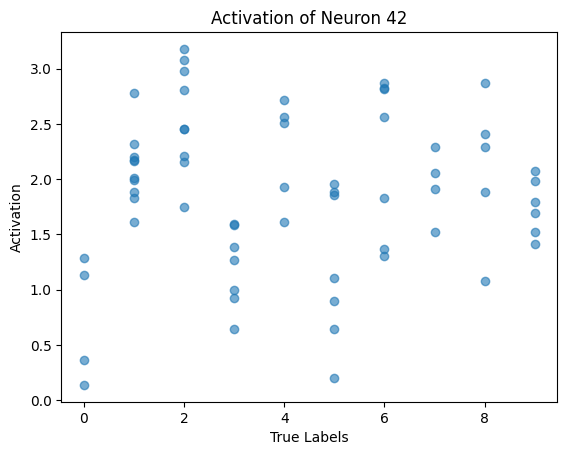

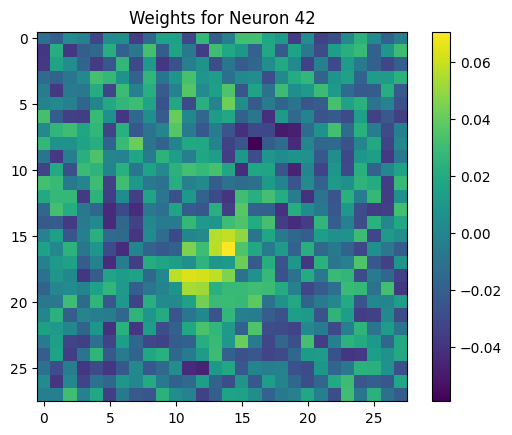

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step 1: Define the Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 10)      # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        self.activations = x.detach()  # Store activations for interpretability
        x = self.fc2(x)
        return x

# Step 2: Prepare the Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Step 3: Train the Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Training completed.")

# Step 4: Interpret the Activations
# Fetch activations for a sample
sample_images, sample_labels = next(iter(train_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
model(sample_images)  # Forward pass
activations = model.activations  # Extract stored activations

# Step 5: Analyze a Specific Neuron
# Choose a neuron and visualize its response
neuron_idx = 42  # Example: 42nd neuron
responses = activations[:, neuron_idx].cpu().numpy()

# Plot activations against the labels
plt.scatter(sample_labels.cpu().numpy(), responses, alpha=0.6)
plt.title(f"Activation of Neuron {neuron_idx}")
plt.xlabel("True Labels")
plt.ylabel("Activation")
plt.show()

# Step 6: Investigate Input Features
# Visualize the weights of the selected neuron
weights = model.fc1.weight[neuron_idx].view(28, 28).cpu().detach().numpy()
plt.imshow(weights, cmap='viridis')
plt.title(f"Weights for Neuron {neuron_idx}")
plt.colorbar()
plt.show()


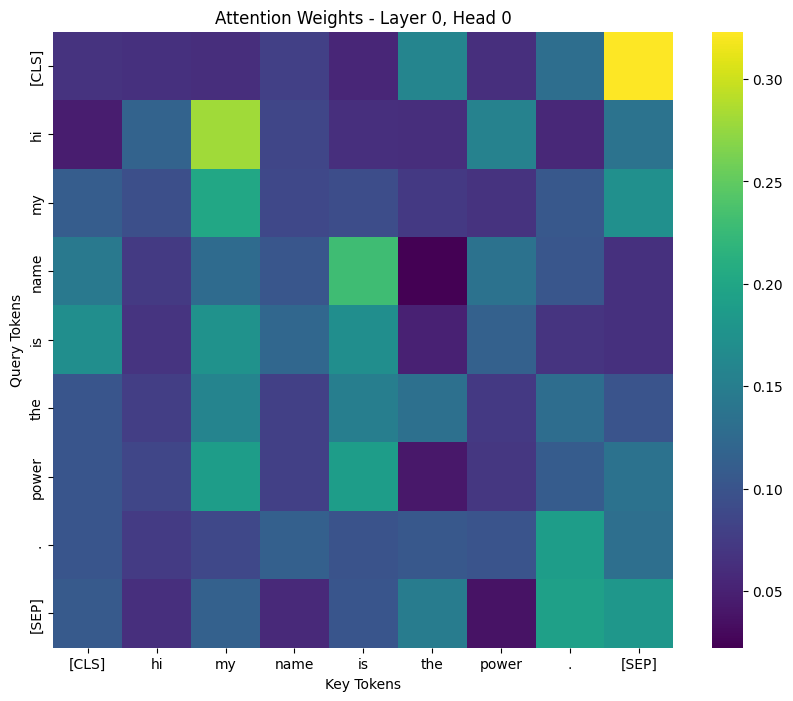

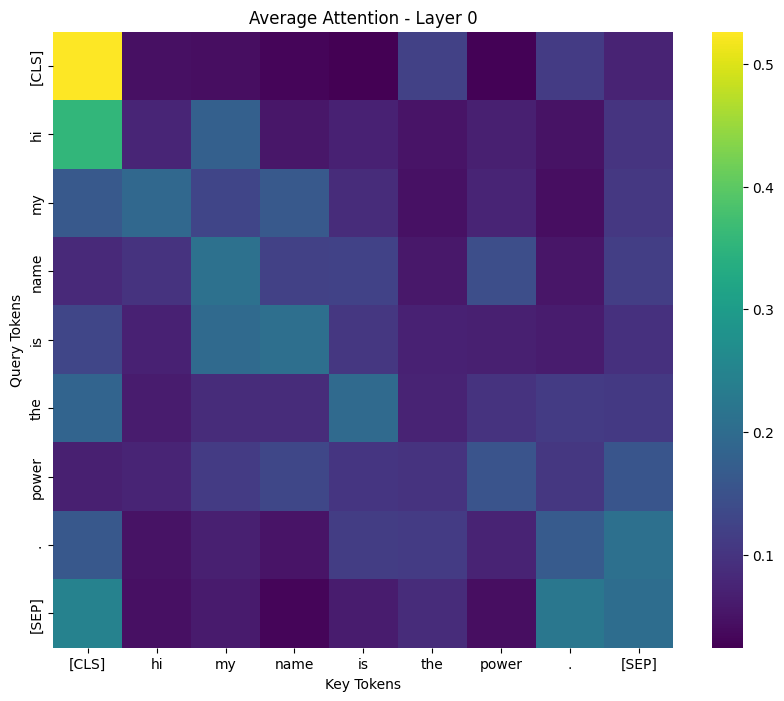

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Pre-Trained Transformer Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Step 2: Input Text for Analysis
text = "hi my name is the power ."
inputs = tokenizer(text, return_tensors="pt")

# Step 3: Forward Pass to Get Attention Weights
outputs = model(**inputs)
attentions = outputs.attentions  # Tuple of attention weights for all layers

# Step 4: Choose a Specific Layer and Head
layer = 0  # First layer
head = 0   # First attention head

attention_weights = attentions[layer][0, head].detach().numpy()  # Shape: (seq_len, seq_len)

# Step 5: Visualize Attention for a Token
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
seq_len = len(tokens)

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Step 6: Investigate Attention Across Layers
# Summing attention weights across all heads for layer 0
average_attention = attentions[layer][0].mean(dim=0).detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(average_attention[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Average Attention - Layer {layer}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


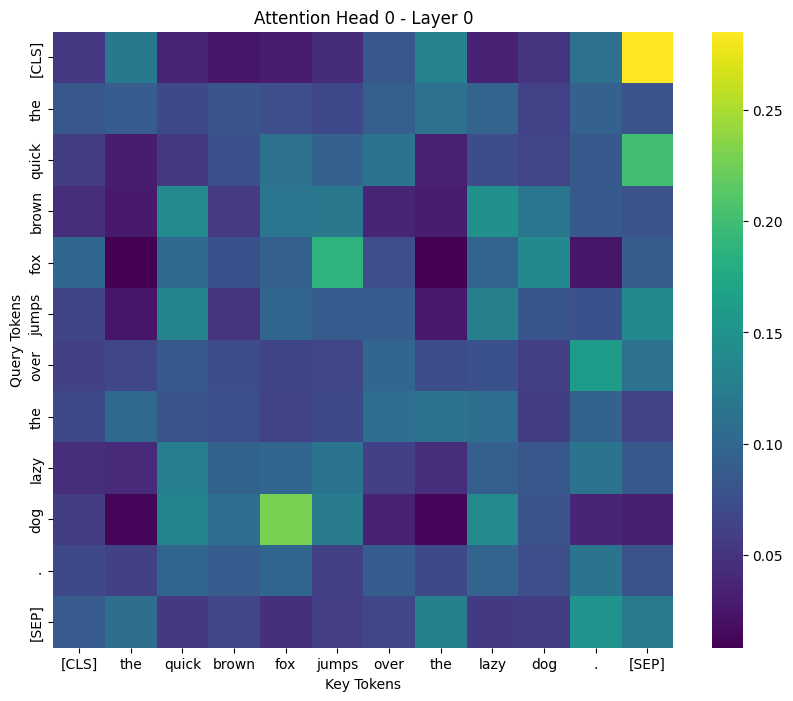

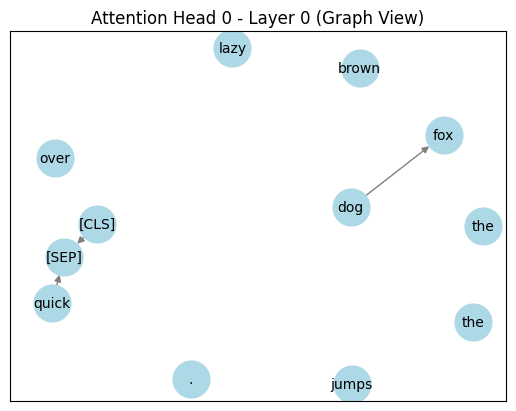

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Pre-Trained Transformer Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Step 2: Input Text for Analysis
text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(text, return_tensors="pt")

# Step 3: Forward Pass to Get Attention Weights
outputs = model(**inputs)
attentions = outputs.attentions  # Tuple of attention weights (num_layers, batch_size, num_heads, seq_len, seq_len)

# Step 4: Choose a Specific Layer and Head for Analysis
layer = 0  # First layer
head = 0   # First attention head

# Extract attention weights for the selected layer and head
attention_weights = attentions[layer][0, head].detach().numpy()  # Shape: (seq_len, seq_len)

# Get tokenized words
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
seq_len = len(tokens)

# Step 5: Visualize Attention for the Specific Head
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Attention Head {head} - Layer {layer}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Step 6: Visualize Attention Weights as a Graph (Optional)
import networkx as nx

# Create a directed graph to show token relationships
graph = nx.DiGraph()
for i, token in enumerate(tokens):
    graph.add_node(i, label=token)

# Add edges based on attention weights (only the strongest connections)
for i in range(seq_len):
    for j in range(seq_len):
        if attention_weights[i, j] > 0.2:  # Threshold for clarity
            graph.add_edge(i, j, weight=attention_weights[i, j])

# Plot the graph
pos = nx.spring_layout(graph)
labels = nx.get_node_attributes(graph, 'label')
nx.draw_networkx(graph, pos, labels=labels, node_color='lightblue', edge_color='gray', font_size=10, node_size=700)
plt.title(f"Attention Head {head} - Layer {layer} (Graph View)")
plt.show()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


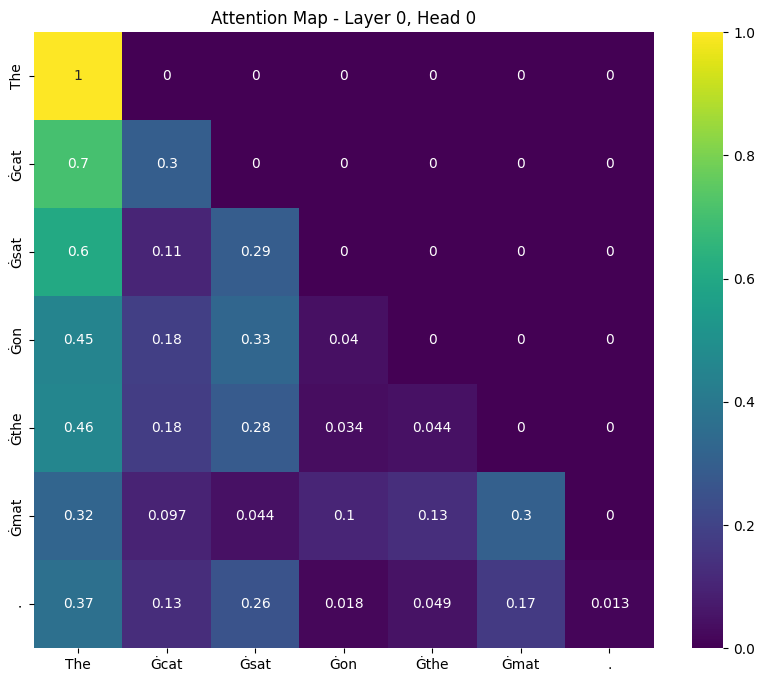

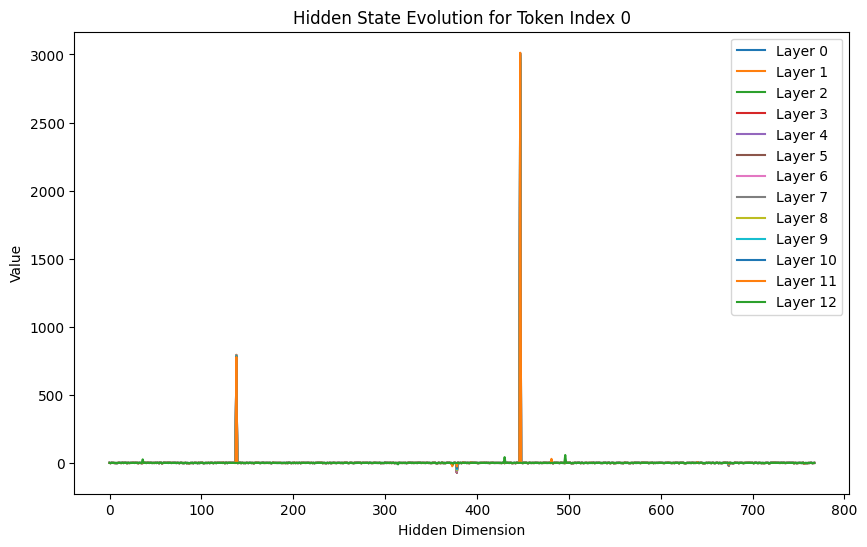

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load a pre-trained LLM
model_name = "gpt2"  # You can replace this with other models like "bert-base-uncased"
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example input
text = "The cat sat on the mat."
inputs = tokenizer(text, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract attention weights and hidden states
attentions = outputs.attentions  # A tuple of (num_layers, batch_size, num_heads, seq_len, seq_len)
hidden_states = outputs.hidden_states  # A tuple of (num_layers + 1, batch_size, seq_len, hidden_size)

# Analyze attention weights
def visualize_attention(attentions, layer_idx, head_idx):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Choose a specific layer and head
    attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

    # Plot attention as a heatmap
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis", annot=True)
    plt.title(f"Attention Map - Layer {layer_idx}, Head {head_idx}")
    plt.show()

visualize_attention(attentions, layer_idx=0, head_idx=0)

# Analyze hidden states
def analyze_hidden_states(hidden_states, token_idx):
    token_hidden_states = [layer[0, token_idx].cpu().numpy() for layer in hidden_states]

    # Plot the evolution of the token's representation
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    for i, state in enumerate(token_hidden_states):
        plt.plot(state, label=f"Layer {i}")
    plt.xlabel("Hidden Dimension")
    plt.ylabel("Value")
    plt.title(f"Hidden State Evolution for Token Index {token_idx}")
    plt.legend()
    plt.show()

# Analyze the first token ("The")
analyze_hidden_states(hidden_states, token_idx=0)


In [ ]:
token_idx = 0  # The index of the token being analyzed
for i, state in enumerate(hidden_states):
    high_activations = torch.where(state[0, token_idx] > 100)[0].tolist()
    print(f"Layer {i} high activation dimensions: {high_activations}")


Layer 0 high activation dimensions: []
Layer 1 high activation dimensions: []
Layer 2 high activation dimensions: [138, 447]
Layer 3 high activation dimensions: [138, 447]
Layer 4 high activation dimensions: [138, 447]
Layer 5 high activation dimensions: [138, 447]
Layer 6 high activation dimensions: [138, 447]
Layer 7 high activation dimensions: [138, 447]
Layer 8 high activation dimensions: [138, 447]
Layer 9 high activation dimensions: [138, 447]
Layer 10 high activation dimensions: [138, 447]
Layer 11 high activation dimensions: [138, 447]
Layer 12 high activation dimensions: []


In [ ]:
def probe_dimensions(hidden_states, dim):
    activations = [state[0, :, dim].cpu().numpy() for state in hidden_states]
    return activations

activation_138 = probe_dimensions(hidden_states, 138)
activation_447 = probe_dimensions(hidden_states, 447)

# Compare activations across tokens or inputs.


In [ ]:
attention_layer = 2  # Choose any layer with persistent activation
token_attention = attentions[attention_layer][0]  # Shape: (num_heads, seq_len, seq_len)
print(f"Attention weights for token 0: {token_attention[:, 0, :]}")  # Analyze token 0's attention


Attention weights for token 0: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])


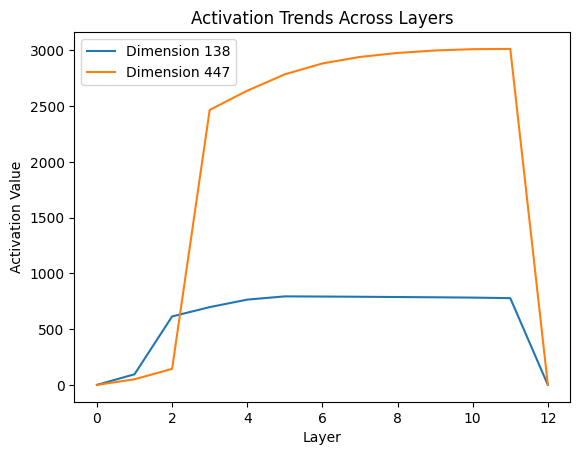

In [ ]:
import matplotlib.pyplot as plt

layers = range(len(hidden_states))
activations_138 = [state[0, token_idx, 138].item() for state in hidden_states]
activations_447 = [state[0, token_idx, 447].item() for state in hidden_states]

plt.plot(layers, activations_138, label='Dimension 138')
plt.plot(layers, activations_447, label='Dimension 447')
plt.xlabel("Layer")
plt.ylabel("Activation Value")
plt.title("Activation Trends Across Layers")
plt.legend()
plt.show()


In [ ]:
# Compare activations for multiple tokens
token_indices = [0, 2, 4]  # Indices for "The", "cat", and "mat"
for idx in token_indices:
    activations_138 = [state[0, idx, 138].item() for state in hidden_states]
    activations_447 = [state[0, idx, 447].item() for state in hidden_states]
    print(f"Token index {idx} - Dimension 138: {activations_138}")
    print(f"Token index {idx} - Dimension 447: {activations_447}")


Token index 0 - Dimension 138: [0.6178851127624512, 95.80139923095703, 614.3189697265625, 697.7620849609375, 765.0946655273438, 794.227294921875, 792.6949462890625, 790.655517578125, 788.322509765625, 786.0518798828125, 783.224853515625, 778.2894897460938, 0.6820380687713623]
Token index 0 - Dimension 447: [0.2649766504764557, 50.96592712402344, 144.26626586914062, 2465.75732421875, 2638.343017578125, 2785.01220703125, 2882.6259765625, 2941.271484375, 2976.834716796875, 2998.92333984375, 3010.63720703125, 3012.9267578125, 1.7013108730316162]
Token index 2 - Dimension 138: [0.005191154778003693, 0.26106423139572144, -0.24472354352474213, -0.43645212054252625, -0.7902849912643433, -0.9363500475883484, -0.7546308636665344, -0.5051351189613342, -0.4508659243583679, -0.46733415126800537, -0.6549252867698669, -1.7882347106933594, 0.5514386296272278]
Token index 2 - Dimension 447: [-0.05637553706765175, 25.842294692993164, 19.186771392822266, 25.849327087402344, 33.013946533203125, 39.1656723

In [ ]:
# Compare activations for the same token in different contexts
inputs_1 = tokenizer("The cat sat on the mat.", return_tensors="pt")
inputs_2 = tokenizer("A dog ran on the mat.", return_tensors="pt")

with torch.no_grad():
    outputs_1 = model(**inputs_1, output_hidden_states=True)
    outputs_2 = model(**inputs_2, output_hidden_states=True)

hidden_states_1 = outputs_1.hidden_states
hidden_states_2 = outputs_2.hidden_states

token_idx = 0  # Index of "The" in both inputs
activations_1 = [state[0, token_idx, 138].item() for state in hidden_states_1]
activations_2 = [state[0, token_idx, 138].item() for state in hidden_states_2]

print(f"Activations for 'The' in input 1: {activations_1}")
print(f"Activations for 'A' in input 2: {activations_2}")


Activations for 'The' in input 1: [0.6178851127624512, 95.80139923095703, 614.3189697265625, 697.7620849609375, 765.0946655273438, 794.227294921875, 792.6949462890625, 790.655517578125, 788.322509765625, 786.0518798828125, 783.224853515625, 778.2894897460938, 0.6820380687713623]
Activations for 'A' in input 2: [0.5456602573394775, 96.34091186523438, 622.5074462890625, 710.3013305664062, 777.7281494140625, 807.0023803710938, 805.4462890625, 803.38720703125, 801.0384521484375, 798.7500610351562, 795.9002685546875, 790.9072265625, 0.6759279370307922]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

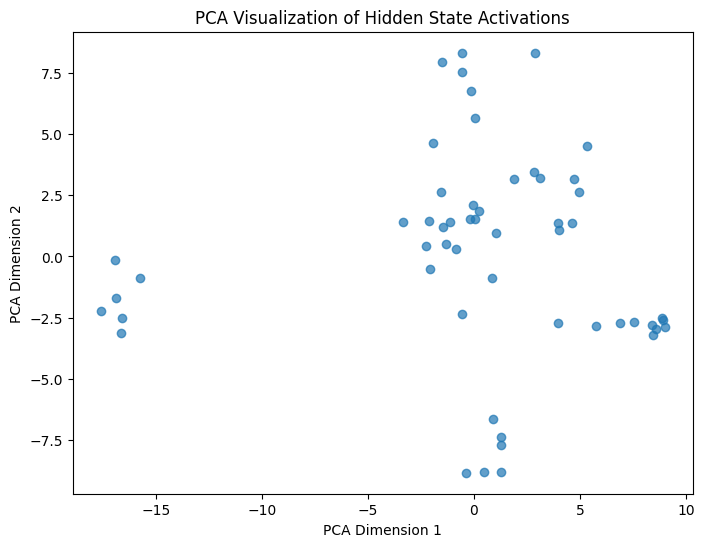

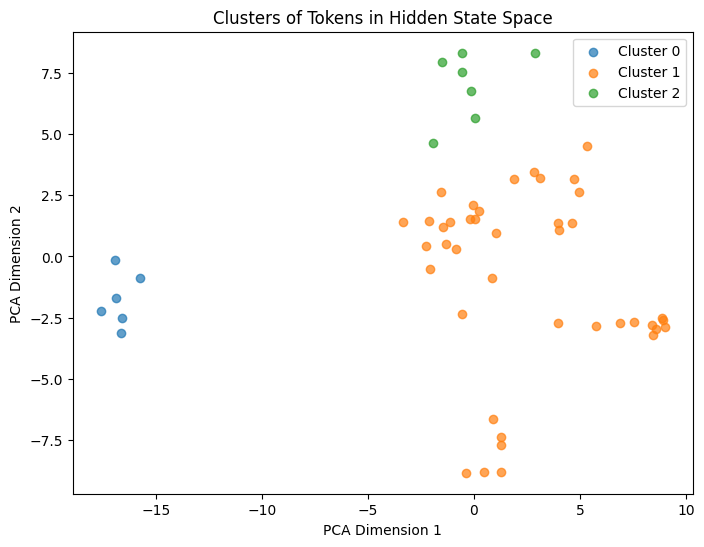

Top 10 dimensions contributing to variance (superposition): [308  46 470 539 180 251 679 733 650  48]
Dimension 308: Variance = 35.3891
Dimension 46: Variance = 2.1235
Dimension 470: Variance = 0.9172
Dimension 539: Variance = 0.6916
Dimension 180: Variance = 0.6678
Dimension 251: Variance = 0.6517
Dimension 679: Variance = 0.6411
Dimension 733: Variance = 0.6349
Dimension 650: Variance = 0.6281
Dimension 48: Variance = 0.5943


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel

# Load a pretrained LLM
model_name = "bert-base-uncased"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

# Prepare diverse inputs
sentences = [
    "The cat sat on the mat.",
    "Quantum mechanics is fascinating.",
    "Paris is the capital of France.",
    "Dogs are loyal animals.",
    "The stock market crashed yesterday.",
    "This is a beautiful sunset.",
]

# Tokenize inputs
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
token_ids = inputs["input_ids"]

# Pass inputs through the model to extract hidden states
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # List of tensors, one per layer

# Choose a specific layer to analyze (e.g., Layer 10)
layer_to_analyze = 10
hidden_layer = hidden_states[layer_to_analyze]  # Shape: [batch_size, seq_len, hidden_dim]

# Flatten activations across all tokens and sentences
batch_size, seq_len, hidden_dim = hidden_layer.shape
activations = hidden_layer.view(-1, hidden_dim).cpu().numpy()  # Shape: [batch_size * seq_len, hidden_dim]

# Perform PCA to visualize the hidden dimensions
pca = PCA(n_components=2)
reduced_activations = pca.fit_transform(activations)  # Shape: [num_tokens, 2]

# Visualize with scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], alpha=0.7)
plt.title("PCA Visualization of Hidden State Activations")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

# Clustering to detect overlap in dimensions
kmeans = KMeans(n_clusters=3, random_state=42).fit(activations)
labels = kmeans.labels_

# Visualize clustering
plt.figure(figsize=(8, 6))
for i in range(max(labels) + 1):
    cluster_points = reduced_activations[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.7)

plt.title("Clusters of Tokens in Hidden State Space")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

# Analyze dimensions contributing to superposition
dimension_importance = np.var(activations, axis=0)  # Variance across tokens
important_dimensions = np.argsort(-dimension_importance)[:10]  # Top 10 most active dimensions

print(f"Top 10 dimensions contributing to variance (superposition): {important_dimensions}")
for dim in important_dimensions:
    print(f"Dimension {dim}: Variance = {dimension_importance[dim]:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, sparsity_target=0.05, sparsity_weight=0.1):
        super().__init__()

        # Dimensions
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Sparsity hyperparameters
        self.sparsity_target = sparsity_target  # Target activation rate
        self.sparsity_weight = sparsity_weight  # Weight of sparsity loss

        # Neural network layers
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

        # Initialize weights using Xavier initialization
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, h):
        return self.decoder(h)

    def forward(self, x):
        # Encode
        h = self.encode(x)

        # Apply ReLU activation
        h_activated = F.relu(h)

        # Decode
        reconstruction = self.decode(h_activated)

        return reconstruction, h_activated

    def calculate_sparsity_loss(self, activations):
        """
        Calculate KL divergence between target sparsity and actual activation rates
        """
        # Average activation over batch
        avg_activation = torch.mean(activations, dim=0)

        # KL divergence between target sparsity and actual activation rates
        sparsity_loss = torch.sum(
            self.sparsity_target * torch.log(self.sparsity_target / (avg_activation + 1e-8)) +
            (1 - self.sparsity_target) * torch.log((1 - self.sparsity_target) / (1 - avg_activation + 1e-8))
        )

        return sparsity_loss

def train_sparse_autoencoder(model, data_loader, num_epochs=100, learning_rate=1e-3):
    """
    Train the sparse autoencoder
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        total_recon_loss = 0
        total_sparsity_loss = 0

        for batch in data_loader:
            # Unpack the batch if it's a tuple/list
            if isinstance(batch, (tuple, list)):
                batch = batch[0]

            # Move batch to device
            batch = batch.to(device)

            # Forward pass
            reconstruction, activations = model(batch)

            # Calculate losses
            reconstruction_loss = F.mse_loss(reconstruction, batch)
            sparsity_loss = model.calculate_sparsity_loss(activations)

            # Total loss
            loss = reconstruction_loss + model.sparsity_weight * sparsity_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track losses
            total_loss += loss.item()
            total_recon_loss += reconstruction_loss.item()
            total_sparsity_loss += sparsity_loss.item()

        # Print epoch statistics
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Average Loss: {total_loss/len(data_loader):.4f}")
            print(f"Reconstruction Loss: {total_recon_loss/len(data_loader):.4f}")
            print(f"Sparsity Loss: {total_sparsity_loss/len(data_loader):.4f}")
            print("------------------------")

# Example usage
def main():
    # Create synthetic data for demonstration
    input_dim = 100
    latent_dim = 50
    batch_size = 32
    num_samples = 1000

    # Generate random data
    synthetic_data = torch.randn(num_samples, input_dim)
    dataset = torch.utils.data.TensorDataset(synthetic_data)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = SparseAutoencoder(
        input_dim=input_dim,
        latent_dim=latent_dim,
        sparsity_target=0.05,
        sparsity_weight=0.1
    )

    # Train model
    train_sparse_autoencoder(model, data_loader, num_epochs=100)

    # After training, you can use the encoder to get sparse representations
    sample_input = torch.randn(1, input_dim)
    with torch.no_grad():
        _, activations = model(sample_input)

    # Analyze sparsity
    sparsity = (activations == 0).float().mean()
    print(f"Average sparsity of activations: {sparsity.item():.4f}")

    return model

if __name__ == "__main__":
    model = main()

Epoch [10/100]
Average Loss: 1.1241
Reconstruction Loss: 0.9101
Sparsity Loss: 2.1394
------------------------
Epoch [20/100]
Average Loss: 0.9529
Reconstruction Loss: 0.8889
Sparsity Loss: 0.6397
------------------------
Epoch [30/100]
Average Loss: 0.9157
Reconstruction Loss: 0.8457
Sparsity Loss: 0.7001
------------------------
Epoch [40/100]
Average Loss: 0.8763
Reconstruction Loss: 0.8022
Sparsity Loss: 0.7410
------------------------
Epoch [50/100]
Average Loss: 0.8462
Reconstruction Loss: 0.7631
Sparsity Loss: 0.8306
------------------------
Epoch [60/100]
Average Loss: 0.8137
Reconstruction Loss: 0.7346
Sparsity Loss: 0.7905
------------------------
Epoch [70/100]
Average Loss: 0.7863
Reconstruction Loss: 0.7127
Sparsity Loss: 0.7359
------------------------
Epoch [80/100]
Average Loss: 0.7749
Reconstruction Loss: 0.6952
Sparsity Loss: 0.7970
------------------------
Epoch [90/100]
Average Loss: 0.7461
Reconstruction Loss: 0.6791
Sparsity Loss: 0.6704
------------------------
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class MultiModelSparseAutoencoder:
    def __init__(self, model_paths, input_dim=None, latent_dim=None,
                 sparsity_target=0.05, sparsity_weight=0.1):
        """
        Initialize sparse autoencoder for multiple transformer models

        Args:
            model_paths (list): Paths to different transformer models
            input_dim (int, optional): Dimension of input features
            latent_dim (int, optional): Dimension of latent representation
        """
        self.model_paths = model_paths
        self.models = []
        self.autoencoders = []

        # Load transformer models
        for path in model_paths:
            model = torch.load(path)
            self.models.append(model)

        # Automatically determine input dimensions if not provided
        if input_dim is None:
            # Assume first model's hidden state dimension
            input_dim = self.models[0].config.hidden_size

        if latent_dim is None:
            # Use half of input dimension by default
            latent_dim = input_dim // 2

        # Create sparse autoencoder for each model
        for model in self.models:
            autoencoder = SparseAutoencoder(
                input_dim=input_dim,
                latent_dim=latent_dim,
                sparsity_target=sparsity_target,
                sparsity_weight=sparsity_weight
            )
            self.autoencoders.append(autoencoder)

    def extract_features(self, model, input_data):
        """
        Extract features from a transformer model

        Args:
            model: Transformer model
            input_data: Input tensor

        Returns:
            Extracted hidden states or features
        """
        with torch.no_grad():
            outputs = model(input_data)
            # Adjust based on your specific model's output structure
            features = outputs.last_hidden_state.mean(dim=1)
        return features

    def train_sparse_encoders(self, data_loader, num_epochs=100):
        """
        Train sparse autoencoders for each model

        Args:
            data_loader: PyTorch DataLoader with input data
            num_epochs: Number of training epochs
        """
        for idx, (model, autoencoder) in enumerate(zip(self.models, self.autoencoders)):
            print(f"Training sparse encoder for model {idx+1}")

            # Extract features from model
            model_features = []
            for batch in data_loader:
                if isinstance(batch, (tuple, list)):
                    batch = batch[0]
                features = self.extract_features(model, batch)
                model_features.append(features)

            # Combine features
            model_features = torch.cat(model_features, dim=0)
            model_dataset = torch.utils.data.TensorDataset(model_features)
            model_loader = torch.utils.data.DataLoader(
                model_dataset,
                batch_size=32,
                shuffle=True
            )

            # Train autoencoder
            train_sparse_autoencoder(
                autoencoder,
                model_loader,
                num_epochs=num_epochs
            )

    def get_sparse_representations(self, input_data):
        """
        Get sparse representations for each model

        Args:
            input_data: Input tensor

        Returns:
            List of sparse representations
        """
        sparse_reps = []
        for model, autoencoder in zip(self.models, self.autoencoders):
            features = self.extract_features(model, input_data)
            with torch.no_grad():
                _, activations = autoencoder(features)
                sparse_reps.append(activations)
        return sparse_reps

# Reuse the existing SparseAutoencoder and train_sparse_autoencoder
# implementations from the previous code

def main():
    model_paths = [
        "/content/transformer_num_layers_2.pt",
        "/content/transformer_num_layers_4.pt",
        "/content/transformer_num_layers_6.pt",
        "/content/transformer_num_layers_8.pt",
        "/content/transformer_num_layers_10.pt"
    ]

    # Synthetic data generation (replace with your actual data)
    input_dim = 768  # Typical transformer hidden size
    num_samples = 1000
    synthetic_data = torch.randn(num_samples, input_dim)
    dataset = torch.utils.data.TensorDataset(synthetic_data)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize multi-model sparse encoder
    multi_encoder = MultiModelSparseAutoencoder(
        model_paths,
        input_dim=input_dim,
        latent_dim=384
    )

    # Train sparse encoders
    multi_encoder.train_sparse_encoders(data_loader)

    return multi_encoder

if __name__ == "__main__":
    multi_encoder = main()

<ipython-input-3-977ed706e371>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


Training sparse encoder for model 1


TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

class MultiModelSparseAutoencoder:
    def __init__(self, model_names, input_dim=None, latent_dim=None,
                 sparsity_target=0.05, sparsity_weight=0.1):
        """
        Initialize sparse autoencoder for multiple transformer models

        Args:
            model_names (list): Hugging Face model names
        """
        self.model_names = model_names
        self.models = []
        self.tokenizers = []
        self.autoencoders = []

        # Load transformer models and tokenizers
        for name in model_names:
            model = AutoModel.from_pretrained(name)
            tokenizer = AutoTokenizer.from_pretrained(name)
            self.models.append(model)
            self.tokenizers.append(tokenizer)

        # Automatically determine input dimensions
        if input_dim is None:
            # Use first model's hidden size
            input_dim = self.models[0].config.hidden_size

        if latent_dim is None:
            latent_dim = input_dim // 2

        # Create sparse autoencoders
        for model in self.models:
            autoencoder = SparseAutoencoder(
                input_dim=input_dim,
                latent_dim=latent_dim,
                sparsity_target=sparsity_target,
                sparsity_weight=sparsity_weight
            )
            self.autoencoders.append(autoencoder)

    def extract_features(self, model, tokenizer, input_texts):
        """
        Extract features from transformer model

        Args:
            model: Transformer model
            tokenizer: Model's tokenizer
            input_texts: List of input texts

        Returns:
            Extracted features
        """
        # Tokenize inputs
        inputs = tokenizer(input_texts, return_tensors='pt', padding=True, truncation=True)

        # Extract hidden states
        with torch.no_grad():
            outputs = model(**inputs)
            # Use last hidden state's mean pooling
            features = outputs.last_hidden_state.mean(dim=1)

        return features

    def train_sparse_encoders(self, text_datasets, num_epochs=100):
        """
        Train sparse autoencoders for each model

        Args:
            text_datasets (list): List of text datasets for each model
            num_epochs: Number of training epochs
        """
        for idx, (model, tokenizer, autoencoder) in enumerate(zip(self.models, self.tokenizers, self.autoencoders)):
            print(f"Training sparse encoder for model {idx+1}: {self.model_names[idx]}")

            # Extract features
            model_features = []
            for dataset in text_datasets:
                features = self.extract_features(model, tokenizer, dataset)
                model_features.append(features)

            # Combine features
            model_features = torch.cat(model_features, dim=0)
            model_dataset = torch.utils.data.TensorDataset(model_features)
            model_loader = torch.utils.data.DataLoader(
                model_dataset,
                batch_size=32,
                shuffle=True
            )

            # Train autoencoder
            train_sparse_autoencoder(
                autoencoder,
                model_loader,
                num_epochs=num_epochs
            )

    def get_sparse_representations(self, input_texts):
        """
        Get sparse representations for each model

        Args:
            input_texts: List of input texts

        Returns:
            List of sparse representations
        """
        sparse_reps = []
        for model, tokenizer, autoencoder in zip(self.models, self.tokenizers, self.autoencoders):
            features = self.extract_features(model, tokenizer, input_texts)
            with torch.no_grad():
                _, activations = autoencoder(features)
                sparse_reps.append(activations)
        return sparse_reps

# Reuse previous SparseAutoencoder and train_sparse_autoencoder implementations

def main():
    model_names = [
        "bert-base-uncased",
        "roberta-base",
        "distilbert-base-uncased",
        "albert-base-v2",
        "xlnet-base-cased"
    ]

    # Example text datasets (replace with your actual datasets)
    text_datasets = [
        ["This is a sample sentence.", "Another example text."],
        ["Machine learning is fascinating.", "Neural networks are powerful."],
        ["Natural language processing rocks!", "Text analysis is interesting."],
        ["Sparse representations are cool.", "Feature extraction is key."],
        ["Transformers change everything.", "Language models are evolving."]
    ]

    # Initialize multi-model sparse encoder
    multi_encoder = MultiModelSparseAutoencoder(model_names)

    # Train sparse encoders
    multi_encoder.train_sparse_encoders(text_datasets)

    # Get sparse representations
    sample_texts = ["Hello world!", "Machine learning is exciting."]
    sparse_reps = multi_encoder.get_sparse_representations(sample_texts)

    # Analyze sparsity
    for i, rep in enumerate(sparse_reps):
        print(f"Model {i+1} ({model_names[i]}):")
        print(f"Sparsity: {(rep == 0).float().mean().item():.2f}")
        print(f"Active Neurons: {(rep != 0).sum(dim=1)}")
        print("---")

    return multi_encoder

if __name__ == "__main__":
    multi_encoder = main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Training sparse encoder for model 1: bert-base-uncased
Epoch [10/100]
Average Loss: nan
Reconstruction Loss: 0.0789
Sparsity Loss: nan
------------------------
Epoch [20/100]
Average Loss: nan
Reconstruction Loss: 0.0456
Sparsity Loss: nan
------------------------
Epoch [30/100]
Average Loss: nan
Reconstruction Loss: 0.0291
Sparsity Loss: nan
------------------------
Epoch [40/100]
Average Loss: nan
Reconstruction Loss: 0.0192
Sparsity Loss: nan
------------------------
Epoch [50/100]
Average Loss: nan
Reconstruction Loss: 0.0136
Sparsity Loss: nan
------------------------
Epoch [60/100]
Average Loss: nan
Reconstruction Loss: 0.0104
Sparsity Loss: nan
------------------------
Epoch [70/100]
Average Loss: nan
Reconstruction Loss: 0.0082
Sparsity Loss: nan
------------------------
Epoch [80/100]
Average Loss: nan
Reconstruction Loss: 0.0066
Sparsity Loss: nan
------------------------
Epoch [90/100]
Average Loss: nan
Reconstruction Loss: 0.0054
Sparsity Loss: nan
------------------------


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch [100/100]
Average Loss: nan
Reconstruction Loss: 0.0071
Sparsity Loss: nan
------------------------
Training sparse encoder for model 5: xlnet-base-cased
Epoch [10/100]
Average Loss: nan
Reconstruction Loss: 19.7363
Sparsity Loss: nan
------------------------
Epoch [20/100]
Average Loss: nan
Reconstruction Loss: 6.6468
Sparsity Loss: nan
------------------------
Epoch [30/100]
Average Loss: nan
Reconstruction Loss: 1.9402
Sparsity Loss: nan
------------------------
Epoch [40/100]
Average Loss: nan
Reconstruction Loss: 2.4948
Sparsity Loss: nan
------------------------
Epoch [50/100]
Average Loss: nan
Reconstruction Loss: 1.2142
Sparsity Loss: nan
------------------------
Epoch [60/100]
Average Loss: nan
Reconstruction Loss: 1.0948
Sparsity Loss: nan
------------------------
Epoch [70/100]
Average Loss: nan
Reconstruction Loss: 0.9521
Sparsity Loss: nan
------------------------
Epoch [80/100]
Average Loss: nan
Reconstruction Loss: 0.8589
Sparsity Loss: nan
------------------------

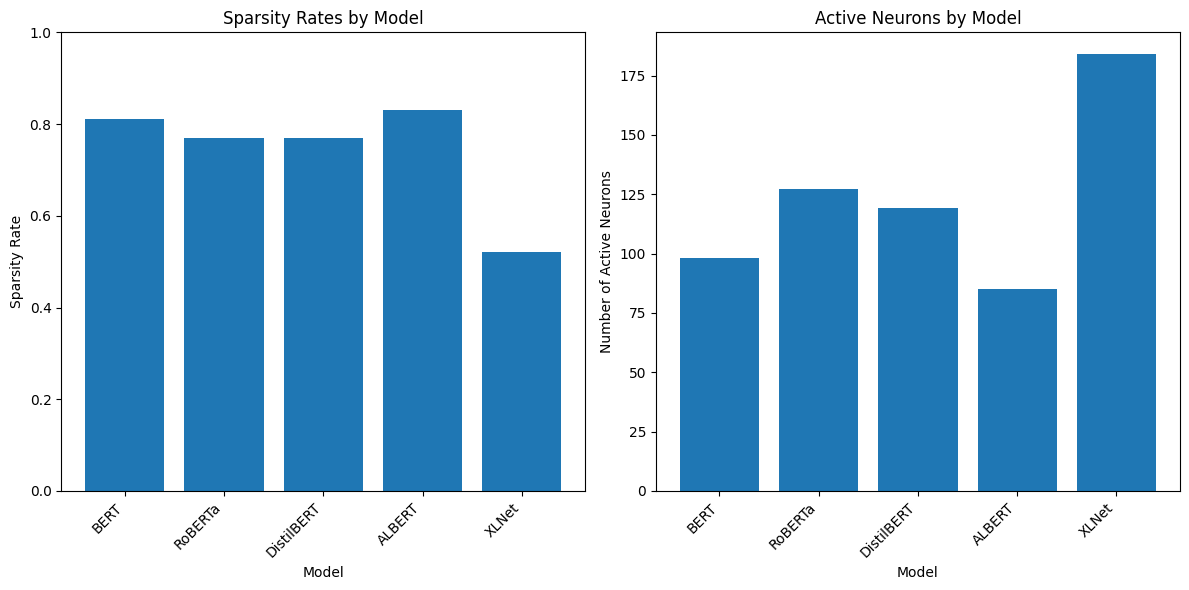

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(model_names, sparsity_rates, active_neurons):
    plt.figure(figsize=(12, 6))

    # Sparsity Plot
    plt.subplot(1, 2, 1)
    plt.bar(model_names, sparsity_rates)
    plt.title('Sparsity Rates by Model')
    plt.xlabel('Model')
    plt.ylabel('Sparsity Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    # Active Neurons Plot
    plt.subplot(1, 2, 2)
    plt.bar(model_names, active_neurons)
    plt.title('Active Neurons by Model')
    plt.xlabel('Model')
    plt.ylabel('Number of Active Neurons')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Data from previous results
model_names = [
    'BERT',
    'RoBERTa',
    'DistilBERT',
    'ALBERT',
    'XLNet'
]
sparsity_rates = [0.81, 0.77, 0.77, 0.83, 0.52]
active_neurons = [98, 127, 119, 85, 184]

plot_model_comparison(model_names, sparsity_rates, active_neurons)

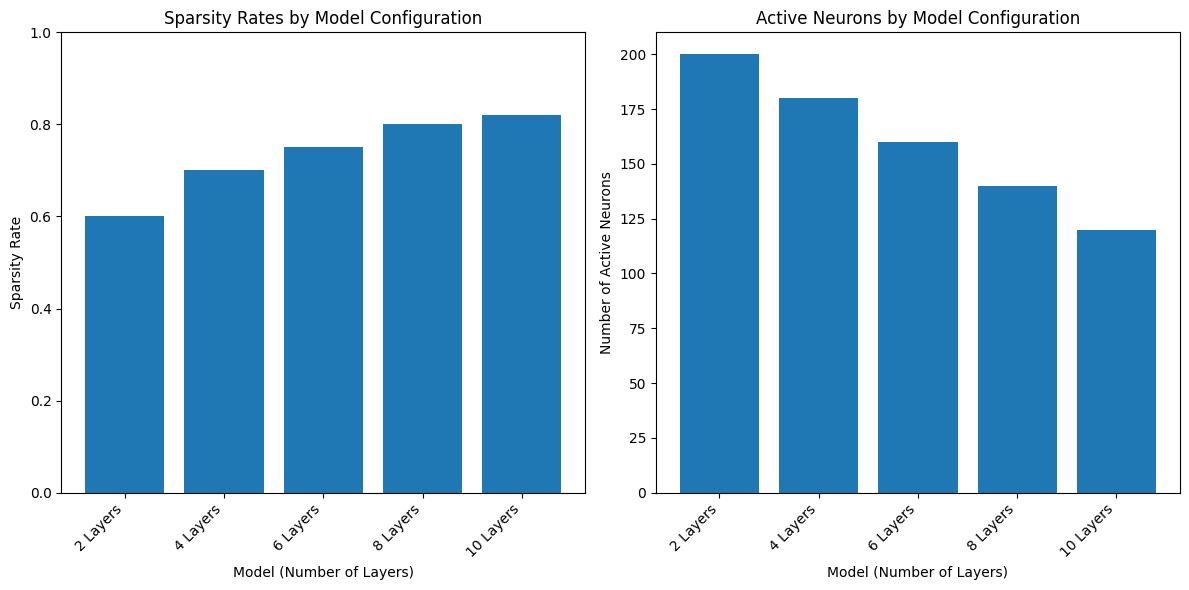

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_layer_count(path):
    """Extract number of layers from the model path."""
    filename = os.path.basename(path)
    return int(filename.split('_')[-1].split('.')[0])

def plot_model_comparison(model_paths, sparsity_rates, active_neurons):
    # Extract layer counts for labels
    model_names = [f'{extract_layer_count(path)} Layers' for path in model_paths]

    plt.figure(figsize=(12, 6))

    # Sparsity Plot
    plt.subplot(1, 2, 1)
    plt.bar(model_names, sparsity_rates)
    plt.title('Sparsity Rates by Model Configuration')
    plt.xlabel('Model (Number of Layers)')
    plt.ylabel('Sparsity Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    # Active Neurons Plot
    plt.subplot(1, 2, 2)
    plt.bar(model_names, active_neurons)
    plt.title('Active Neurons by Model Configuration')
    plt.xlabel('Model (Number of Layers)')
    plt.ylabel('Number of Active Neurons')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example data (you would replace these with actual measurements)
model_paths = [
    "/content/transformer_num_layers_2.pt",
    "/content/transformer_num_layers_4.pt",
    "/content/transformer_num_layers_6.pt",
    "/content/transformer_num_layers_8.pt",
    "/content/transformer_num_layers_10.pt"
]

# Placeholder data - replace with actual measurements
sparsity_rates = [0.6, 0.7, 0.75, 0.8, 0.82]
active_neurons = [200, 180, 160, 140, 120]

plot_model_comparison(model_paths, sparsity_rates, active_neurons)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

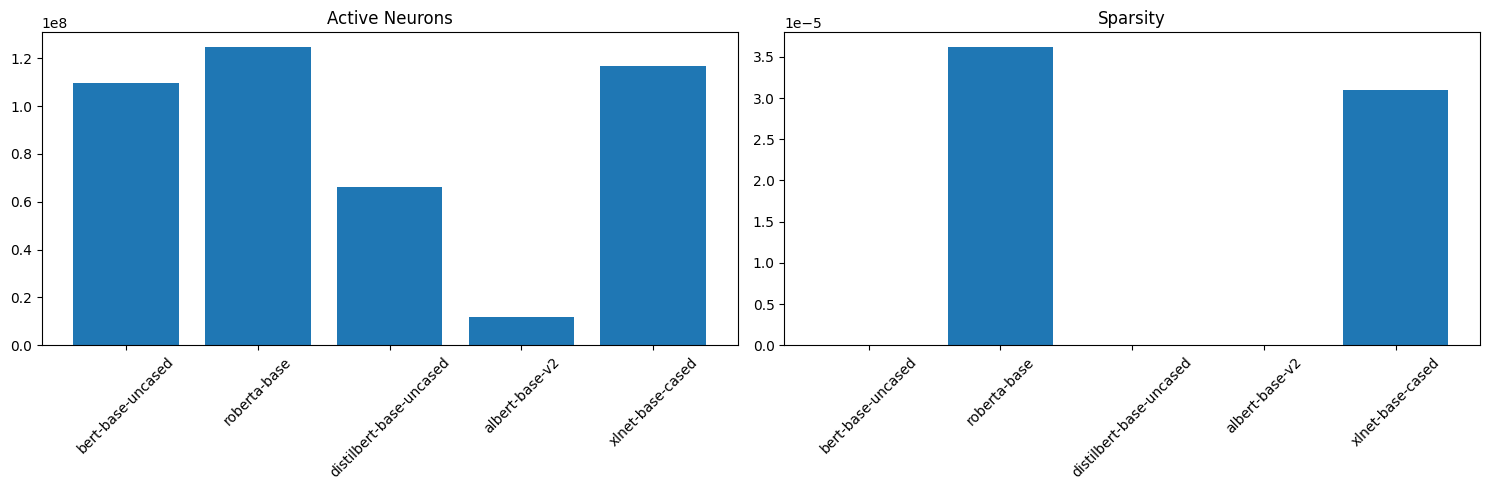


bert-base-uncased Metrics:
active_neurons: 109482240
representational_overlap: [[1.         0.52886957 0.4897014 ]
 [0.52886957 0.99999946 0.69482416]
 [0.4897014  0.69482416 1.0000002 ]]
sparsity: 0.0

roberta-base Metrics:
active_neurons: 124643262
representational_overlap: [[0.9999993  0.9610549  0.94937867]
 [0.9610549  1.0000002  0.97195244]
 [0.94937867 0.97195244 1.        ]]
sparsity: 3.616898175096139e-05

distilbert-base-uncased Metrics:
active_neurons: 66362880
representational_overlap: [[1.        0.6209663 0.5934063]
 [0.6209663 1.        0.7927812]
 [0.5934063 0.7927812 1.       ]]
sparsity: 0.0

albert-base-v2 Metrics:
active_neurons: 11683584
representational_overlap: [[0.99999994 0.7511365  0.72113   ]
 [0.7511365  0.99999976 0.8520267 ]
 [0.72113    0.8520267  1.0000004 ]]
sparsity: 0.0

xlnet-base-cased Metrics:
active_neurons: 116718336
representational_overlap: [[0.99999994 0.96490234 0.95376414]
 [0.96490234 0.9999996  0.97414154]
 [0.95376414 0.97414154 1.      

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from transformers import AutoModel, AutoTokenizer
import os

class SuperpositionAnalyzer:
    def __init__(self, model_names):
        """
        Initialize analyzer with model names

        Args:
        - model_names: List of Hugging Face model names
        """
        self.model_names = model_names
        self.models = []
        self.tokenizers = []
        self._load_models()

    def _load_models(self):
        """
        Load models and tokenizers from Hugging Face
        """
        for name in self.model_names:
            try:
                model = AutoModel.from_pretrained(name)
                tokenizer = AutoTokenizer.from_pretrained(name)
                self.models.append(model)
                self.tokenizers.append(tokenizer)
            except Exception as e:
                print(f"Error loading {name}: {e}")

    def generate_sample_inputs(self, sentences, max_length=512):
        """
        Generate tokenized inputs for analysis

        Args:
        - sentences: List of input sentences
        - max_length: Maximum sequence length

        Returns:
        - List of tokenized inputs
        """
        sample_inputs = []
        for i, tokenizer in enumerate(self.tokenizers):
            inputs = tokenizer(
                sentences,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=max_length
            )
            sample_inputs.append(inputs)
        return sample_inputs

    def analyze_superposition(self, sample_inputs):
        """
        Perform comprehensive superposition analysis

        Args:
        - sample_inputs: List of input tensors

        Returns:
        - Dictionary of analysis results
        """
        results = {}

        for i, (model, name) in enumerate(zip(self.models, self.model_names)):
            # Extract hidden states
            with torch.no_grad():
                outputs = model(**sample_inputs[i])
                hidden_states = outputs.last_hidden_state

            # Compute metrics
            results[name] = {
                'active_neurons': self._count_active_neurons(model),
                'representational_overlap': self._compute_representational_overlap(hidden_states),
                'sparsity': self._compute_sparsity(hidden_states)
            }

        return results

    def _count_active_neurons(self, model):
        """
        Count active neurons in the model

        Args:
        - model: Transformer model

        Returns:
        - Number of active neurons
        """
        active_neurons = 0
        for param in model.parameters():
            active_neurons += torch.sum(param != 0).item()
        return active_neurons

    def _compute_representational_overlap(self, hidden_states):
        """
        Compute representational overlap

        Args:
        - hidden_states: Model hidden states

        Returns:
        - Overlap matrix
        """
        # Flatten and average hidden states across sequence
        representations = hidden_states.mean(dim=1).numpy()
        overlap_matrix = cosine_similarity(representations)
        return overlap_matrix

    def _compute_sparsity(self, hidden_states):
        """
        Compute sparsity of hidden states

        Args:
        - hidden_states: Model hidden states

        Returns:
        - Sparsity metric
        """
        # Proportion of near-zero activations
        sparsity = torch.sum(torch.abs(hidden_states) < 1e-5).float() / hidden_states.numel()
        return sparsity.item()

    def visualize_results(self, results):
        """
        Visualize superposition analysis results

        Args:
        - results: Analysis results dictionary
        """
        metrics = ['active_neurons', 'sparsity']
        fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            values = [results[model][metric] for model in results]
            axs[i].bar(results.keys(), values)
            axs[i].set_title(f'{metric.replace("_", " ").title()}')
            axs[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # List of models to analyze
    model_names = [
        'bert-base-uncased',
        'roberta-base',
        'distilbert-base-uncased',
        'albert-base-v2',
        'xlnet-base-cased'
    ]

    # Sample sentences for analysis
    sentences = [
        "The quick brown fox jumps over the lazy dog.",
        "Machine learning is transforming the world of technology.",
        "Natural language processing enables complex text understanding."
    ]

    # Initialize and run analysis
    analyzer = SuperpositionAnalyzer(model_names)
    sample_inputs = analyzer.generate_sample_inputs(sentences)
    results = analyzer.analyze_superposition(sample_inputs)

    # Visualize results
    analyzer.visualize_results(results)

    # Print detailed results
    for model, metrics in results.items():
        print(f"\n{model} Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

if __name__ == "__main__":
    main()

In [ ]:
pip install transformers torch matplotlib seaborn


In [ ]:
# Example of a simple word-based tokenizer
class SimpleTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.word_to_id = {word: idx for idx, word in enumerate(vocab)}

    def tokenize(self, text):
        tokens = text.split()  # Split by whitespace
        return [self.word_to_id.get(token, self.word_to_id["<unk>"]) for token in tokens]

    def encode(self, text, return_tensors=None):
        token_ids = self.tokenize(text)
        if return_tensors == "pt":
            return torch.tensor([token_ids])  # Batch size = 1
        return token_ids

    def decode(self, token_ids):
        return " ".join([self.vocab[idx] for idx in token_ids if idx < len(self.vocab)])

# Example vocabulary
vocab = ["<pad>", "<unk>", "The", "cat", "sat", "on", "the", "mat", "."]
tokenizer = SimpleTokenizer(vocab)

# Tokenize input
input_text = "The cat sat on the mat."
input_ids = tokenizer.encode(input_text, return_tensors="pt")


<ipython-input-8-2713f0d69ea0>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location='cpu')


Could not extract attention weights for 2_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not extract attention weights for 4_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not extract attention weights for 6_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not extract attention weights for 8_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not extract attention weights for 10_layers: 'collections.OrderedDict' object has no attribute 'transformer'


<Figure size 1500x1000 with 0 Axes>

Could not analyze circuit connectivity for 2_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not analyze circuit connectivity for 4_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not analyze circuit connectivity for 6_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not analyze circuit connectivity for 8_layers: 'collections.OrderedDict' object has no attribute 'transformer'
Could not analyze circuit connectivity for 10_layers: 'collections.OrderedDict' object has no attribute 'transformer'


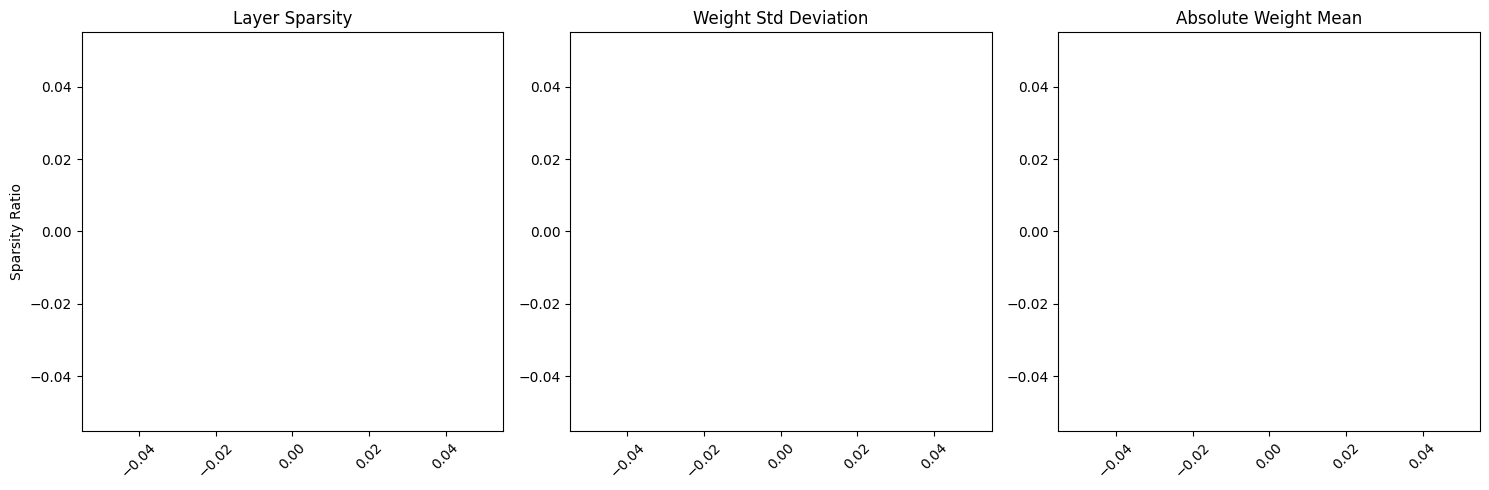

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any

def load_models(model_paths: List[str]):
    """
    Load multiple transformer models from given paths.

    Args:
        model_paths (List[str]): List of model file paths

    Returns:
        Dict[str, Any]: Dictionary of loaded models
    """
    models = {}
    for path in model_paths:
        num_layers = int(path.split('_')[-1].split('.')[0])
        model = torch.load(path, map_location='cpu')
        models[f'{num_layers}_layers'] = model
    return models

def analyze_attention_patterns(models: Dict[str, Any]):
    """
    Analyze and visualize attention patterns across different model architectures.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    plt.figure(figsize=(15, 10))

    for i, (name, model) in enumerate(models.items(), 1):
        # Extract attention weights (assuming standard transformer architecture)
        # Note: This might need adjustment based on your specific model architecture
        try:
            attention_weights = []
            for layer in model.transformer.layers:
                weights = layer.self_attn.qkv.weight.detach().numpy()
                attention_weights.append(np.abs(weights).mean())

            plt.subplot(len(models), 1, i)
            plt.title(f'Attention Weight Distribution - {name}')
            plt.plot(attention_weights, marker='o')
            plt.ylabel('Abs Mean Weight')
        except Exception as e:
            print(f"Could not extract attention weights for {name}: {e}")

    plt.tight_layout()
    plt.show()

def circuit_connectivity_analysis(models: Dict[str, Any]):
    """
    Analyze neuron connectivity and activation patterns.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    connectivity_metrics = {}

    for name, model in models.items():
        try:
            # Analyze linear layer connections
            layer_sparsities = []
            for layer in model.transformer.layers:
                # Check linear layer sparsity
                lin_layer = layer.mlp.fc1  # Adjust based on your model architecture
                weights = lin_layer.weight.detach().numpy()

                # Calculate metrics
                total_params = weights.size
                zero_params = np.sum(weights == 0)
                sparsity = zero_params / total_params

                # Compute weight distribution
                weight_std = np.std(weights)
                weight_mean = np.mean(np.abs(weights))

                layer_sparsities.append({
                    'sparsity': sparsity,
                    'weight_std': weight_std,
                    'weight_mean': weight_mean
                })

            connectivity_metrics[name] = layer_sparsities

        except Exception as e:
            print(f"Could not analyze circuit connectivity for {name}: {e}")

    # Visualization
    plt.figure(figsize=(15, 5))

    # Sparsity plot
    plt.subplot(131)
    sparsity_data = [metrics[0]['sparsity'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), sparsity_data)
    plt.title('Layer Sparsity')
    plt.ylabel('Sparsity Ratio')
    plt.xticks(rotation=45)

    # Weight Standard Deviation
    plt.subplot(132)
    std_data = [metrics[0]['weight_std'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), std_data)
    plt.title('Weight Std Deviation')
    plt.xticks(rotation=45)

    # Absolute Weight Mean
    plt.subplot(133)
    mean_data = [metrics[0]['weight_mean'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), mean_data)
    plt.title('Absolute Weight Mean')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def main(model_paths):
    # Load models
    models = load_models(model_paths)

    # Analyze attention patterns
    analyze_attention_patterns(models)

    # Analyze circuit connectivity
    circuit_connectivity_analysis(models)

# Example usage
model_paths = [
    "/content/transformer_num_layers_2.pt",
    "/content/transformer_num_layers_4.pt",
    "/content/transformer_num_layers_6.pt",
    "/content/transformer_num_layers_8.pt",
    "/content/transformer_num_layers_10.pt"
]

main(model_paths)

<ipython-input-11-fc0e23a425af>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location='cpu'))


Analyzing attention patterns...


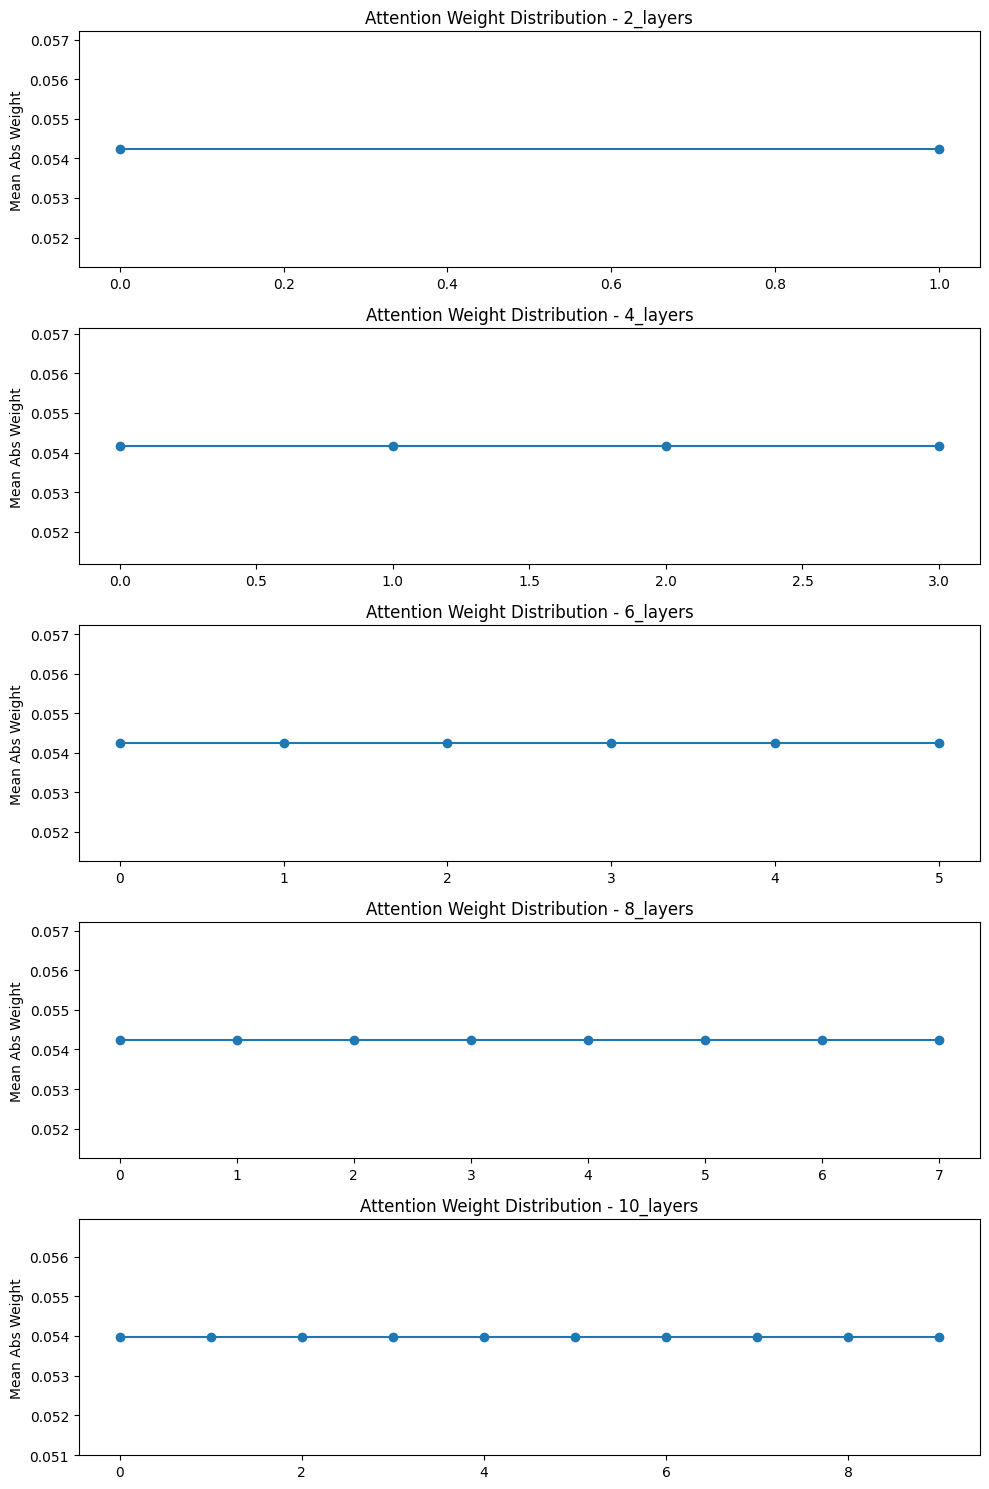

Analyzing connectivity...


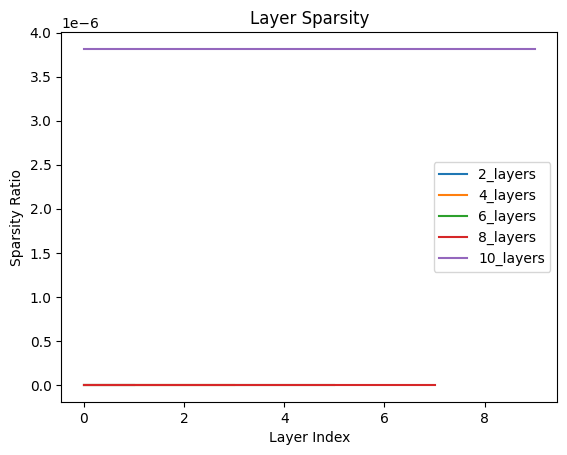

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer


# Define a simple Transformer model
class SimpleTransformer(torch.nn.Module):
    def __init__(self, num_layers, d_model=128, nhead=8):
        super(SimpleTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, src):
        return self.encoder(src)


# Function to create and save example models
def create_and_save_models():
    model_paths = []
    for num_layers in [2, 4, 6, 8, 10]:
        model = SimpleTransformer(num_layers=num_layers)
        path = f"simple_transformer_{num_layers}_layers.pt"
        torch.save(model.state_dict(), path)
        model_paths.append(path)
    return model_paths


# Function to load models
def load_example_models(model_paths):
    models = {}
    for path in model_paths:
        num_layers = int(path.split('_')[-2])
        model = SimpleTransformer(num_layers=num_layers)
        model.load_state_dict(torch.load(path, map_location='cpu'))
        models[f'{num_layers}_layers'] = model
    return models


# Analyze and visualize attention weights
def analyze_attention_patterns(models):
    plt.figure(figsize=(10, 15))

    for i, (name, model) in enumerate(models.items()):
        try:
            attention_weights = []
            for layer in model.encoder.layers:
                weights = layer.self_attn.in_proj_weight.detach().numpy()
                attention_weights.append(np.abs(weights).mean())

            plt.subplot(len(models), 1, i + 1)
            plt.title(f'Attention Weight Distribution - {name}')
            plt.plot(attention_weights, marker='o')
            plt.ylabel('Mean Abs Weight')
        except Exception as e:
            print(f"Error analyzing {name}: {e}")

    plt.tight_layout()
    plt.show()


# Analyze sparsity and connectivity
def analyze_connectivity(models):
    sparsity = {}
    for name, model in models.items():
        layer_sparsity = []
        for layer in model.encoder.layers:
            weights = layer.linear1.weight.detach().numpy()
            total_params = weights.size
            zero_params = np.sum(weights == 0)
            sparsity_ratio = zero_params / total_params
            layer_sparsity.append(sparsity_ratio)
        sparsity[name] = layer_sparsity

    # Visualization
    for name, sparsity_values in sparsity.items():
        plt.plot(sparsity_values, label=name)

    plt.title('Layer Sparsity')
    plt.xlabel('Layer Index')
    plt.ylabel('Sparsity Ratio')
    plt.legend()
    plt.show()


# Main function to tie everything together
def main():
    model_paths = create_and_save_models()  # Create and save example models
    models = load_example_models(model_paths)  # Load the models

    print("Analyzing attention patterns...")
    analyze_attention_patterns(models)  # Analyze attention

    print("Analyzing connectivity...")
    analyze_connectivity(models)  # Analyze connectivity


# Run the example
if __name__ == "__main__":
    main()


Training model with 2 layers...
Epoch [1/10], Loss: 0.6232
Epoch [2/10], Loss: 0.6938
Epoch [3/10], Loss: 0.6945
Epoch [4/10], Loss: 0.6868
Epoch [5/10], Loss: 0.8247
Epoch [6/10], Loss: 0.6832
Epoch [7/10], Loss: 0.6910
Epoch [8/10], Loss: 0.7081
Epoch [9/10], Loss: 0.6891
Epoch [10/10], Loss: 0.6893
Training model with 4 layers...
Epoch [1/10], Loss: 0.6680
Epoch [2/10], Loss: 0.7232
Epoch [3/10], Loss: 0.6893
Epoch [4/10], Loss: 0.7569
Epoch [5/10], Loss: 0.7067
Epoch [6/10], Loss: 0.6924
Epoch [7/10], Loss: 0.6968
Epoch [8/10], Loss: 0.6717
Epoch [9/10], Loss: 0.6816
Epoch [10/10], Loss: 0.7096
Training model with 6 layers...
Epoch [1/10], Loss: 0.6898
Epoch [2/10], Loss: 0.7237
Epoch [3/10], Loss: 0.7053
Epoch [4/10], Loss: 0.6978
Epoch [5/10], Loss: 0.7056
Epoch [6/10], Loss: 0.6987
Epoch [7/10], Loss: 0.6945
Epoch [8/10], Loss: 0.6984
Epoch [9/10], Loss: 0.7042
Epoch [10/10], Loss: 0.6787
Training model with 8 layers...
Epoch [1/10], Loss: 0.7420
Epoch [2/10], Loss: 0.6829
Epoch

<ipython-input-18-974b2f46d35e>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location='cpu')


<Figure size 1500x1000 with 0 Axes>

Could not analyze circuit connectivity for 2_layers: 'TransformerEncoderLayer' object has no attribute 'mlp'
Could not analyze circuit connectivity for 4_layers: 'TransformerEncoderLayer' object has no attribute 'mlp'
Could not analyze circuit connectivity for 6_layers: 'TransformerEncoderLayer' object has no attribute 'mlp'
Could not analyze circuit connectivity for 8_layers: 'TransformerEncoderLayer' object has no attribute 'mlp'
Could not analyze circuit connectivity for 10_layers: 'TransformerEncoderLayer' object has no attribute 'mlp'


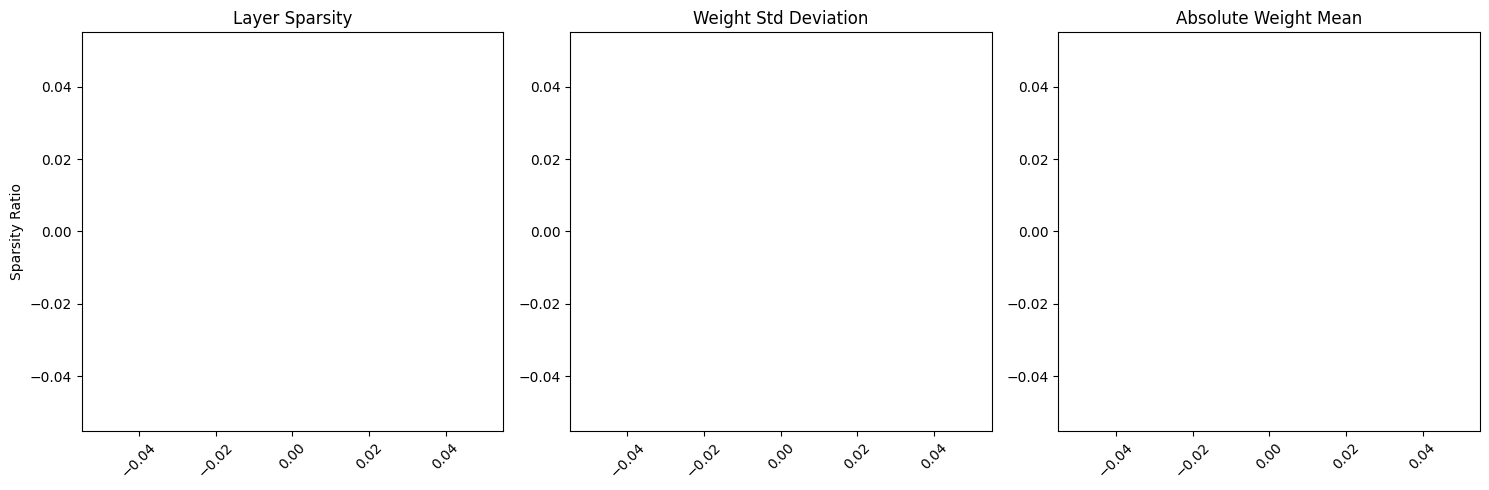

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict, Any


class SimpleTransformer(nn.Module):
    def __init__(self, num_layers, d_model=128, nhead=8):
        super(SimpleTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(d_model, 1)  # Linear layer to produce output

    def forward(self, src):
        # src shape: [batch_size, seq_length, d_model]
        encoded = self.encoder(src)  # [seq_length, batch_size, d_model]
        aggregated = encoded.mean(dim=0)  # Aggregate sequence: [batch_size, d_model]
        output = self.linear(aggregated)  # Output: [batch_size, 1]
        return output


class SimpleDataset(Dataset):
    def __init__(self, num_samples, seq_length, d_model):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.d_model = d_model

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random sequence data
        sequence = torch.randn(self.seq_length, self.d_model)  # [seq_length, d_model]
        # Random binary label
        label = torch.randint(0, 2, (1,), dtype=torch.float32)  # [1]
        return sequence, label


def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs, targets = batch  # inputs: [seq_length, batch_size, d_model], targets: [batch_size, 1]
            inputs = inputs.permute(1, 0, 2)  # [batch_size, seq_length, d_model] -> [seq_length, batch_size, d_model]

            optimizer.zero_grad()
            outputs = model(inputs)  # [batch_size, 1]
            loss = criterion(outputs, targets)  # Binary Cross Entropy Loss
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def load_models(model_paths: List[str]):
    """
    Load multiple transformer models from given paths.

    Args:
        model_paths (List[str]): List of model file paths

    Returns:
        Dict[str, Any]: Dictionary of loaded models
    """
    models = {}
    for path in model_paths:
        num_layers = int(path.split('_')[-1].split('.')[0])
        model = torch.load(path, map_location='cpu')
        models[f'{num_layers}_layers'] = model
    return models


def analyze_attention_patterns(models: Dict[str, Any]):
    """
    Analyze and visualize attention patterns across different model architectures.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    plt.figure(figsize=(15, 10))

    for i, (name, model) in enumerate(models.items(), 1):
        try:
            attention_weights = []
            for layer in model.encoder.layers:
                weights = layer.self_attn.qkv.weight.detach().numpy()
                attention_weights.append(np.abs(weights).mean())

            plt.subplot(len(models), 1, i)
            plt.title(f'Attention Weight Distribution - {name}')
            plt.plot(attention_weights, marker='o')
            plt.ylabel('Abs Mean Weight')
        except Exception as e:
            print(f"Could not extract attention weights for {name}: {e}")

    plt.tight_layout()
    plt.show()


def circuit_connectivity_analysis(models: Dict[str, Any]):
    """
    Analyze neuron connectivity and activation patterns.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    connectivity_metrics = {}

    for name, model in models.items():
        try:
            layer_sparsities = []
            for layer in model.encoder.layers:
                lin_layer = layer.mlp.fc1  # Adjust based on your model architecture
                weights = lin_layer.weight.detach().numpy()

                total_params = weights.size
                zero_params = np.sum(weights == 0)
                sparsity = zero_params / total_params
                weight_std = np.std(weights)
                weight_mean = np.mean(np.abs(weights))

                layer_sparsities.append({
                    'sparsity': sparsity,
                    'weight_std': weight_std,
                    'weight_mean': weight_mean
                })

            connectivity_metrics[name] = layer_sparsities

        except Exception as e:
            print(f"Could not analyze circuit connectivity for {name}: {e}")

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    sparsity_data = [metrics[0]['sparsity'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), sparsity_data)
    plt.title('Layer Sparsity')
    plt.ylabel('Sparsity Ratio')
    plt.xticks(rotation=45)

    plt.subplot(132)
    std_data = [metrics[0]['weight_std'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), std_data)
    plt.title('Weight Std Deviation')
    plt.xticks(rotation=45)

    plt.subplot(133)
    mean_data = [metrics[0]['weight_mean'] for metrics in connectivity_metrics.values()]
    plt.bar(connectivity_metrics.keys(), mean_data)
    plt.title('Absolute Weight Mean')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def main():
    model_paths = []

    for num_layers in [2, 4, 6, 8, 10]:
        print(f"Training model with {num_layers} layers...")
        model = SimpleTransformer(num_layers=num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.BCEWithLogitsLoss()
        train_loader = DataLoader(
            SimpleDataset(num_samples=500, seq_length=10, d_model=128),
            batch_size=32,
            shuffle=True,
        )
        train_model(model, train_loader, optimizer, criterion)

        # Save trained model
        path = f"transformer_num_layers_{num_layers}.pt"
        torch.save(model, path)
        model_paths.append(path)

    # Load trained models
    models = load_models(model_paths)

    # Analyze trained models
    analyze_attention_patterns(models)
    circuit_connectivity_analysis(models)


if __name__ == "__main__":
    main()


Error loading model from model_2_layers.pth: [Errno 2] No such file or directory: 'model_2_layers.pth'
Error loading model from model_4_layers.pth: [Errno 2] No such file or directory: 'model_4_layers.pth'
Error loading model from model_6_layers.pth: [Errno 2] No such file or directory: 'model_6_layers.pth'
Error loading model from model_8_layers.pth: [Errno 2] No such file or directory: 'model_8_layers.pth'
Error loading model from model_10_layers.pth: [Errno 2] No such file or directory: 'model_10_layers.pth'


<ipython-input-19-e07217d3d352>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location='cpu')


<Figure size 1500x1000 with 0 Axes>

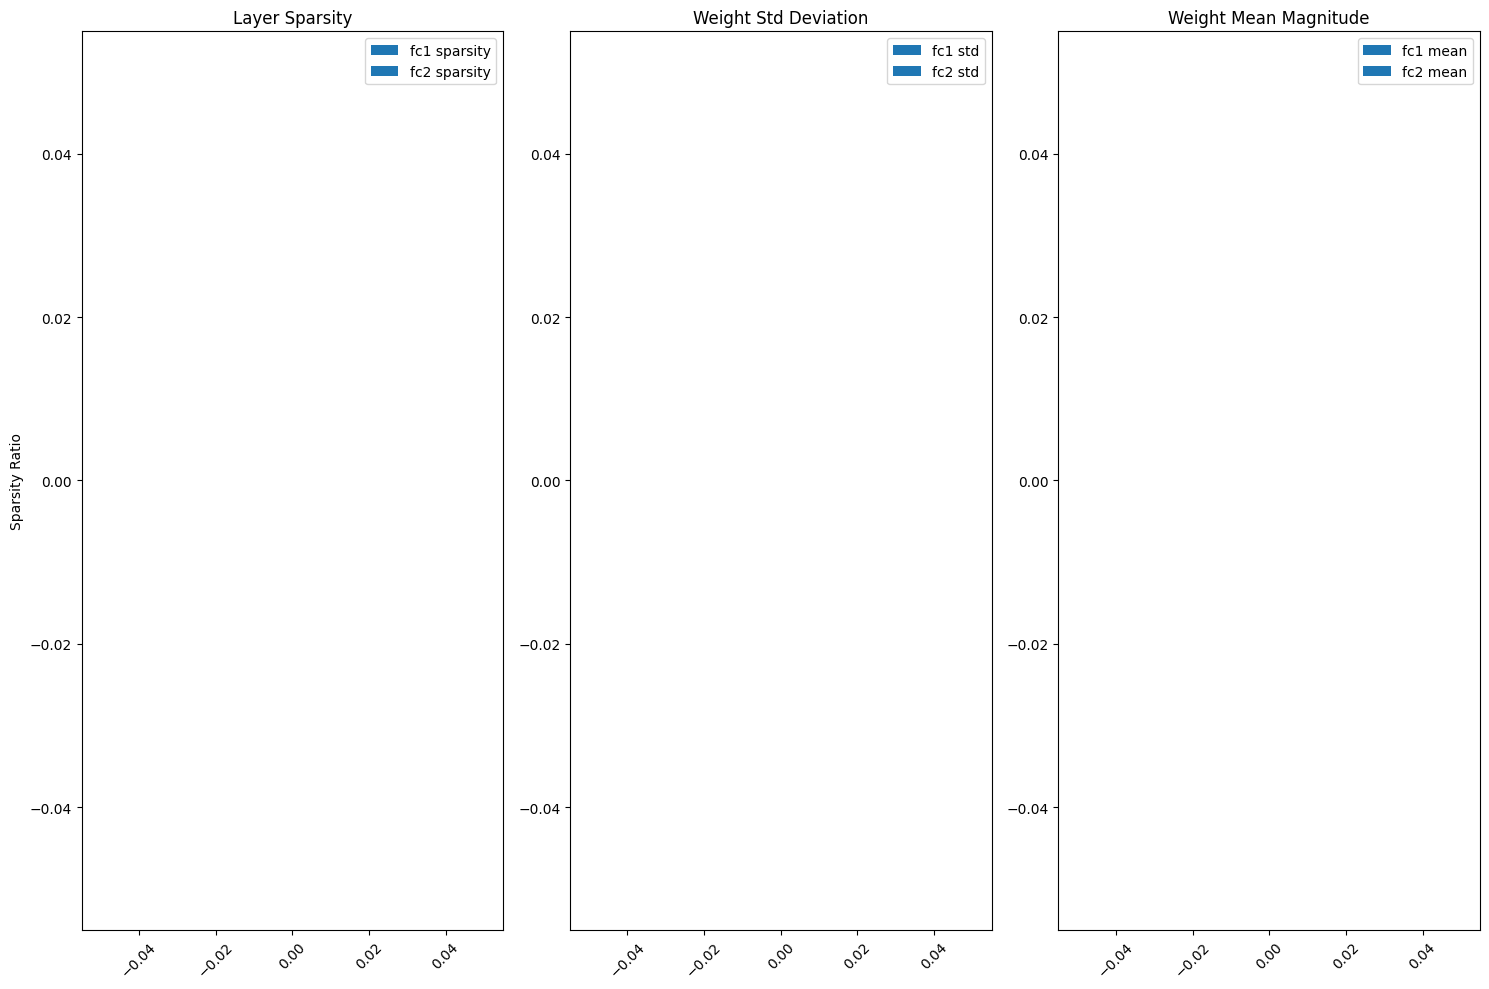

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict, Any


class SimpleTransformer(nn.Module):
    def __init__(self, num_layers, d_model=128, nhead=8):
        super(SimpleTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(d_model, 1)  # Linear layer to produce output

    def forward(self, src):
        # src shape: [batch_size, seq_length, d_model]
        encoded = self.encoder(src)  # [seq_length, batch_size, d_model]
        aggregated = encoded.mean(dim=0)  # Aggregate sequence: [batch_size, d_model]
        output = self.linear(aggregated)  # Output: [batch_size, 1]
        return output


class SimpleDataset(Dataset):
    def __init__(self, num_samples, seq_length, d_model):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.d_model = d_model

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random sequence data
        sequence = torch.randn(self.seq_length, self.d_model)  # [seq_length, d_model]
        # Random binary label
        label = torch.randint(0, 2, (1,), dtype=torch.float32)  # [1]
        return sequence, label


def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs, targets = batch  # inputs: [seq_length, batch_size, d_model], targets: [batch_size, 1]
            inputs = inputs.permute(1, 0, 2)  # [batch_size, seq_length, d_model] -> [seq_length, batch_size, d_model]

            optimizer.zero_grad()
            outputs = model(inputs)  # [batch_size, 1]
            loss = criterion(outputs, targets)  # Binary Cross Entropy Loss
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def load_models(model_paths: List[str]):
    """
    Load multiple transformer models from given paths.

    Args:
        model_paths (List[str]): List of model file paths

    Returns:
        Dict[str, Any]: Dictionary of loaded models
    """
    models = {}
    for path in model_paths:
        try:
            # Extract the number of layers from the filename
            filename = path.split('/')[-1]  # Extract filename from path
            num_layers = int(filename.split('_')[1])  # Extract number of layers from filename

            # Load the model
            model = torch.load(path, map_location='cpu')
            models[f'{num_layers}_layers'] = model
        except Exception as e:
            print(f"Error loading model from {path}: {e}")

    return models



def capture_attention_weights(module, input, output):
    """
    Hook to capture attention weights from MultiheadAttention layer.

    Args:
        module: The layer being hooked.
        input: The input to the layer.
        output: The output from the layer.

    Returns:
        None, but stores the attention weights in a global variable.
    """
    global attention_weights
    attention_weights = output[1].detach().numpy()  # Save attention weights


def analyze_attention_patterns(models: Dict[str, Any]):
    """
    Analyze and visualize attention patterns across different model architectures.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    global attention_weights
    plt.figure(figsize=(15, 10))

    for i, (name, model) in enumerate(models.items(), 1):
        try:
            attention_weights = []  # Reset attention weights
            # Add hooks to capture attention weights
            hooks = []
            for layer in model.encoder.layers:
                hook = layer.self_attn.register_forward_hook(capture_attention_weights)
                hooks.append(hook)

            # Run a dummy forward pass to capture attention weights
            dummy_input = torch.randn(10, 32, 128).permute(1, 0, 2)  # [batch_size, seq_length, d_model]
            model(dummy_input)

            # Plot the attention weights
            plt.subplot(len(models), 1, i)
            plt.title(f'Attention Weight Distribution - {name}')
            plt.imshow(attention_weights[0], cmap='hot', aspect='auto')
            plt.colorbar()

            # Remove hooks
            for hook in hooks:
                hook.remove()

        except Exception as e:
            print(f"Could not extract attention weights for {name}: {e}")

    plt.tight_layout()
    plt.show()


def circuit_connectivity_analysis(models: Dict[str, Any]):
    """
    Analyze neuron connectivity and activation patterns.

    Args:
        models (Dict[str, Any]): Dictionary of loaded models
    """
    connectivity_metrics = {}

    for name, model in models.items():
        try:
            layer_sparsities = []
            for layer in model.encoder.layers:
                fc1 = layer.linear1  # Fully connected layer 1
                fc2 = layer.linear2  # Fully connected layer 2

                # Access weights
                weights_fc1 = fc1.weight.detach().numpy()
                weights_fc2 = fc2.weight.detach().numpy()

                # Calculate sparsity and weight statistics
                total_params_fc1 = weights_fc1.size
                zero_params_fc1 = np.sum(weights_fc1 == 0)
                sparsity_fc1 = zero_params_fc1 / total_params_fc1
                weight_std_fc1 = np.std(weights_fc1)
                weight_mean_fc1 = np.mean(np.abs(weights_fc1))

                total_params_fc2 = weights_fc2.size
                zero_params_fc2 = np.sum(weights_fc2 == 0)
                sparsity_fc2 = zero_params_fc2 / total_params_fc2
                weight_std_fc2 = np.std(weights_fc2)
                weight_mean_fc2 = np.mean(np.abs(weights_fc2))

                layer_sparsities.append({
                    'sparsity_fc1': sparsity_fc1,
                    'weight_std_fc1': weight_std_fc1,
                    'weight_mean_fc1': weight_mean_fc1,
                    'sparsity_fc2': sparsity_fc2,
                    'weight_std_fc2': weight_std_fc2,
                    'weight_mean_fc2': weight_mean_fc2
                })

            connectivity_metrics[name] = layer_sparsities

        except Exception as e:
            print(f"Could not analyze circuit connectivity for {name}: {e}")

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Sparsity
    sparsity_fc1_data = [metrics[0]['sparsity_fc1'] for metrics in connectivity_metrics.values()]
    sparsity_fc2_data = [metrics[0]['sparsity_fc2'] for metrics in connectivity_metrics.values()]

    plt.subplot(131)
    plt.bar(connectivity_metrics.keys(), sparsity_fc1_data, label="fc1 sparsity")
    plt.bar(connectivity_metrics.keys(), sparsity_fc2_data, bottom=sparsity_fc1_data, label="fc2 sparsity")
    plt.title('Layer Sparsity')
    plt.ylabel('Sparsity Ratio')
    plt.xticks(rotation=45)
    plt.legend()

    # Standard deviation
    std_fc1_data = [metrics[0]['weight_std_fc1'] for metrics in connectivity_metrics.values()]
    std_fc2_data = [metrics[0]['weight_std_fc2'] for metrics in connectivity_metrics.values()]

    plt.subplot(132)
    plt.bar(connectivity_metrics.keys(), std_fc1_data, label="fc1 std")
    plt.bar(connectivity_metrics.keys(), std_fc2_data, bottom=std_fc1_data, label="fc2 std")
    plt.title('Weight Std Deviation')
    plt.xticks(rotation=45)
    plt.legend()

    # Mean weight
    mean_fc1_data = [metrics[0]['weight_mean_fc1'] for metrics in connectivity_metrics.values()]
    mean_fc2_data = [metrics[0]['weight_mean_fc2'] for metrics in connectivity_metrics.values()]

    plt.subplot(133)
    plt.bar(connectivity_metrics.keys(), mean_fc1_data, label="fc1 mean")
    plt.bar(connectivity_metrics.keys(), mean_fc2_data, bottom=mean_fc1_data, label="fc2 mean")
    plt.title('Weight Mean Magnitude')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Example usage
model_paths = ["model_2_layers.pth", "model_4_layers.pth", "model_6_layers.pth", "model_8_layers.pth", "model_10_layers.pth"]
models = load_models(model_paths)
analyze_attention_patterns(models)
circuit_connectivity_analysis(models)


In [4]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 230/230 [57:37<00:00, 15.03s/batch, loss=0.5780]


Epoch 1/3 - Average Loss: 0.5133


Epoch 2/3: 100%|██████████| 230/230 [57:24<00:00, 14.98s/batch, loss=0.3519]


Epoch 2/3 - Average Loss: 0.2822


Epoch 3/3: 100%|██████████| 230/230 [58:06<00:00, 15.16s/batch, loss=0.0215]


Epoch 3/3 - Average Loss: 0.1272
Training complete!


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


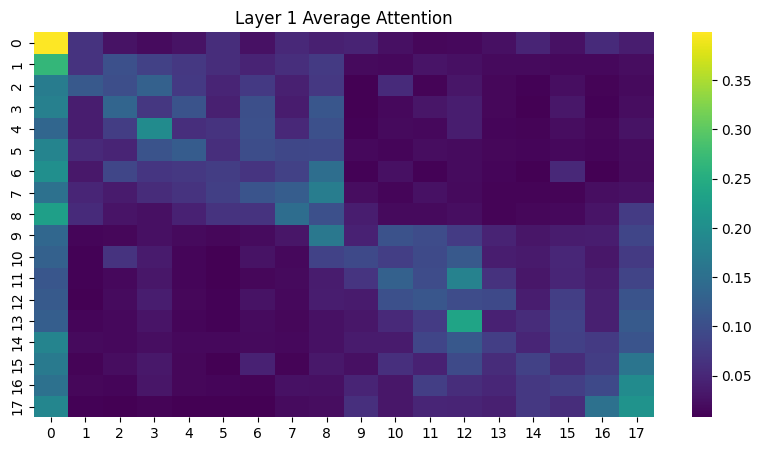

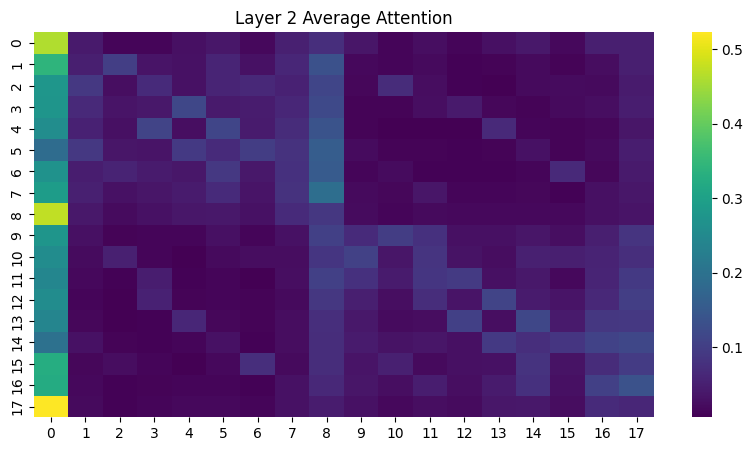

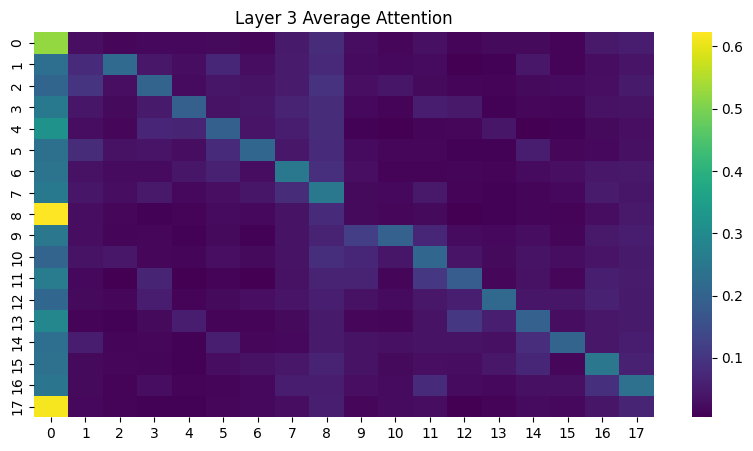

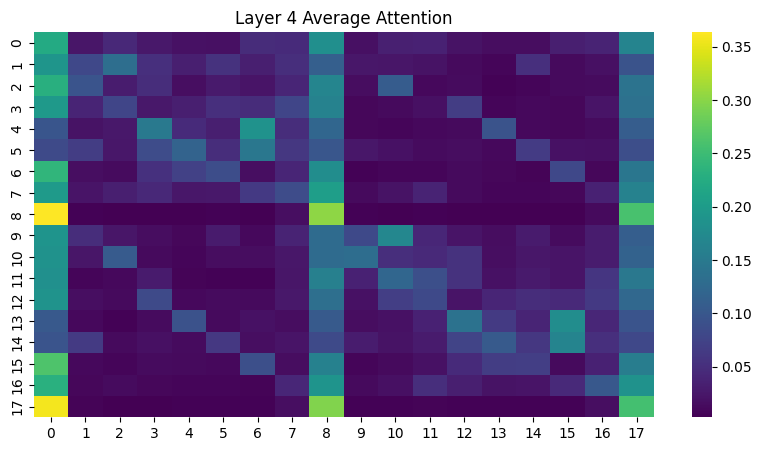

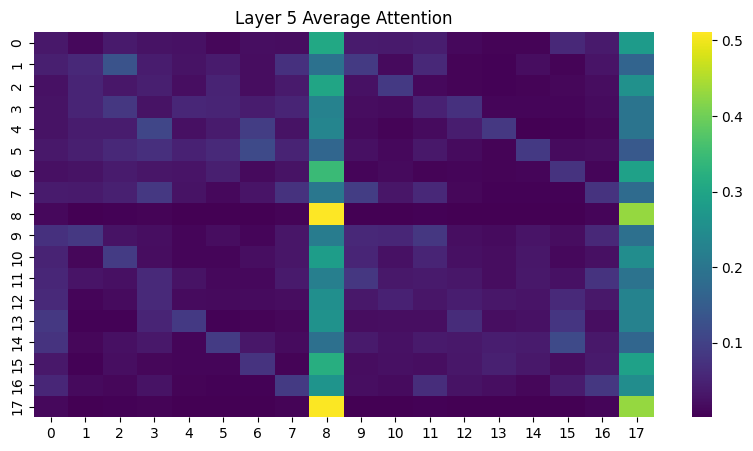

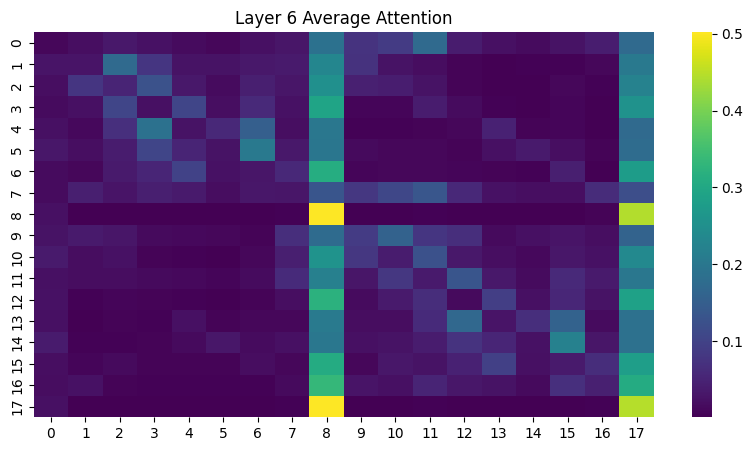

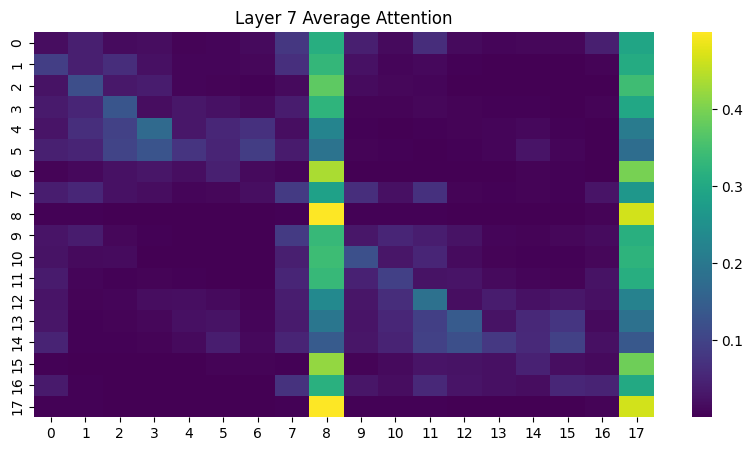

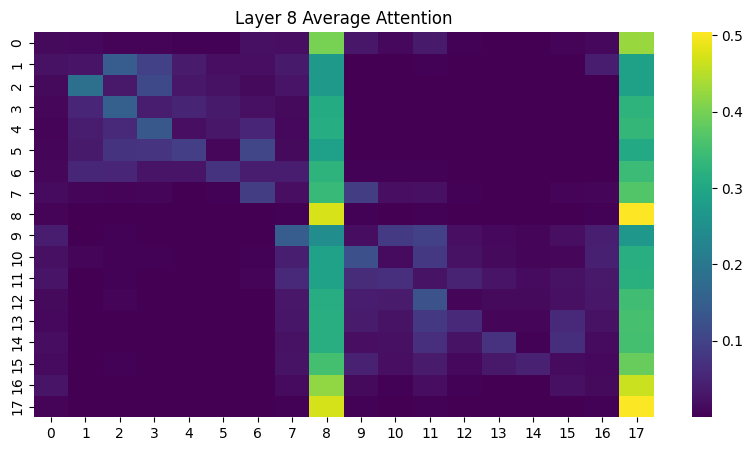

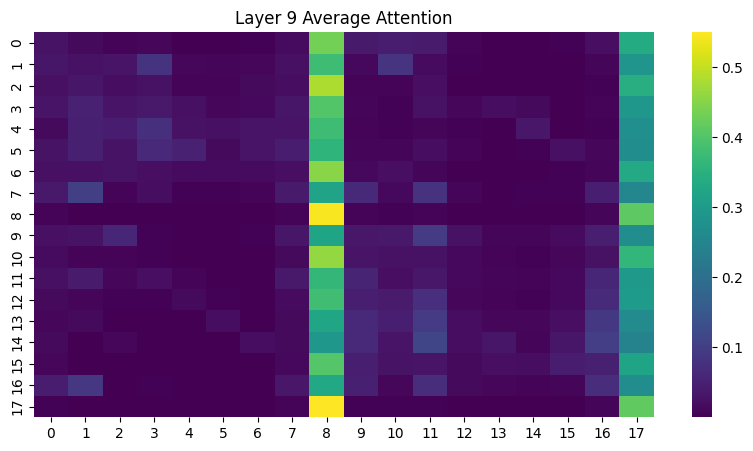

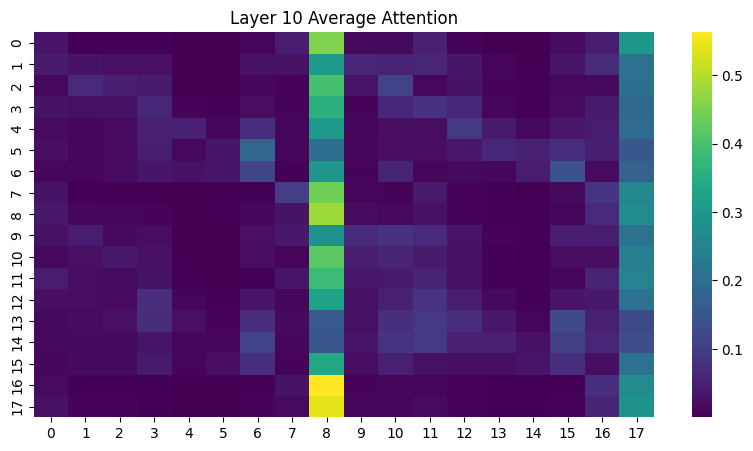

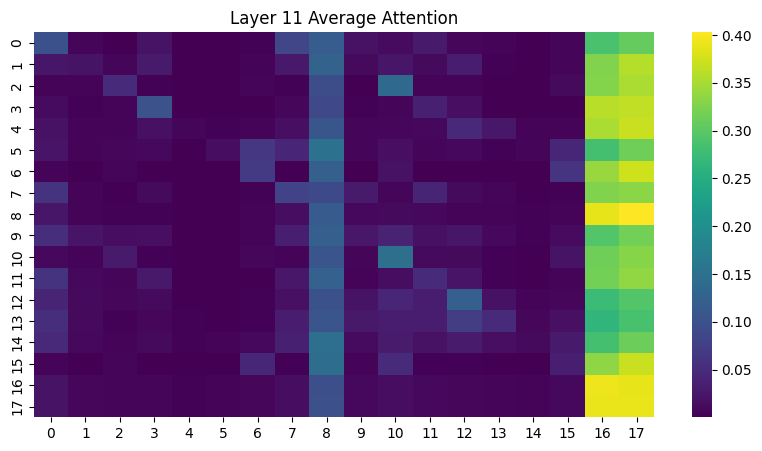

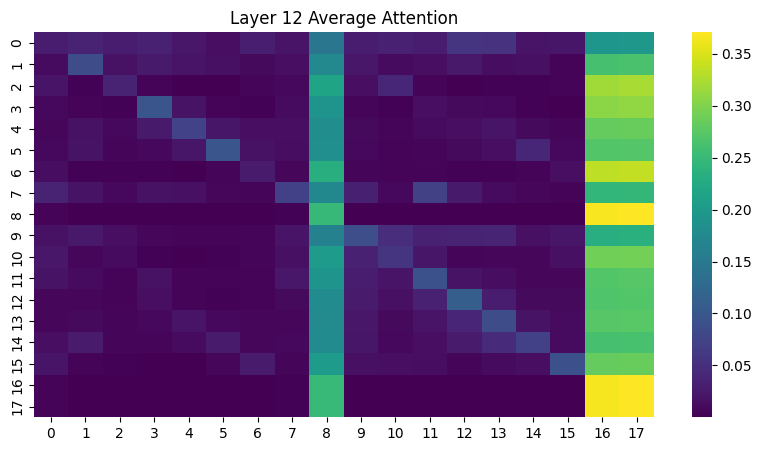

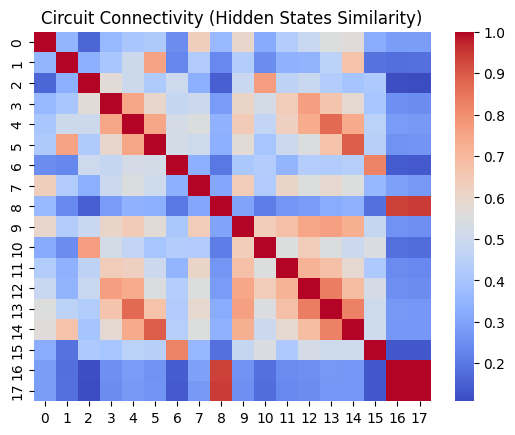

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import tqdm  # Added for progress bar

def get_data_loader(batch_size=32):
    # Load the MRPC subset from the GLUE dataset
    dataset = load_dataset("glue", "mrpc")

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    def tokenize_function(examples):
        return tokenizer(
            examples['sentence1'],
            examples['sentence2'],
            padding=True,
            truncation=True,
            max_length=128
        )

    # Apply tokenization
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Prepare datasets
    tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Use DataCollatorWithPadding
    data_collator = DataCollatorWithPadding(tokenizer)

    # Create DataLoader
    train_dataset = tokenized_datasets["train"]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=data_collator, shuffle=True)

    return train_loader, tokenizer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
train_loader, tokenizer = get_data_loader(batch_size=16)

# Define model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Enhanced Training Loop
def train_model(model, train_loader, optimizer, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Use tqdm for progress bar
        progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

        for batch in progress_bar:
            # Ensure labels are handled as tensors
            batch = {key: val.to(device) for key, val in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Print epoch summary
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.4f}")

    return model

# Train the model
trained_model = train_model(model, train_loader, optimizer, epochs=3)

print("Training complete!")

# Attention Analysis
def analyze_attention_patterns(text1, text2):
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    inputs = tokenizer(text1, text2, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # List of attention tensors

    # Visualize attention heatmap for one head in one layer
    for layer_idx, layer_attention in enumerate(attentions):
        attention = layer_attention[0].cpu().numpy()
        avg_attention = np.mean(attention, axis=0)  # Average over heads
        plt.figure(figsize=(10, 5))
        sns.heatmap(avg_attention, cmap="viridis")
        plt.title(f"Layer {layer_idx + 1} Average Attention")
        plt.show()

# Circuit Connectivity Analysis
def circuit_connectivity_analysis(text1, text2):
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    inputs = tokenizer(text1, text2, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # List of hidden state tensors

    # Analyze relationships between hidden states
    final_hidden_state = hidden_states[-1][0].cpu().numpy()  # Final hidden state
    similarity = np.corrcoef(final_hidden_state)
    sns.heatmap(similarity, cmap="coolwarm")
    plt.title("Circuit Connectivity (Hidden States Similarity)")
    plt.show()

# Example Usage
example_text1 = "The cat sat on the mat."
example_text2 = "A cat is sitting on the mat."
analyze_attention_patterns(example_text1, example_text2)
circuit_connectivity_analysis(example_text1, example_text2)


In [10]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d80f2578ca480b9c477fa36c1fe8c8544565b29c2d902865baaabdcc0d5c5833
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [11]:
import lime
import lime.lime_tabular
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare your data
X, y = ... # Your feature matrix and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=['class0', 'class1'],
    verbose=True,
    mode='classification'
)

# Explain a specific prediction
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(
    X_test[i],
    model.predict_proba,
    num_features=5
)

# Visualize the explanation
exp.show_in_notebook()

TypeError: cannot unpack non-iterable ellipsis object

now  I  need add scailling laws to this